# Mexico Drug Traffic Activities 

# Librerie Usate

In [47]:
import os
import shutil
import itertools
import numpy as np
import collections
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

Inserire percorso della propria cartella

ESEMPIO: /User/mario/Desktop/Mexico_Drug_Traffic_Activities

ATTENZIONE: si prega di non mettere un back slash alla fine del percorso per eviatre errori 
            nell'esecuzione del codice


In [48]:
percorso_cartella = "/Users/emanuele/Desktop/Mexico_Drug_Traffic_Activities" 

In [ ]:
print('''
ATTENZIONE: DOPO AVER CAMBIATO LA POSIZIONE DEI FILE PRESENTI NELLA CARTELLA PRINCIPALE
            NON SARA' PIU' POSSIBILE ESEGUIRE IL CODICE.

            SI CONSIGLIA QUINDI DI SVOLGERE QUESTA OPERAZIONE SOLO ALLA FINE DELL'ANALISI 
            PER ELIMINARE TUTTI I FILE CHE POSSONO ESSERE RIGENEARTI.
''')
print('Se si vole procedere digitare SI, altrimenti digitare NO:')
decision = str(input())
#decision = 'NO'

if decision == 'SI':
    #creiamo cartelle per contenere tutti i file creati
    directory = "files_txt"
    parent_dir = percorso_cartella +'/'
    path = os.path.join(parent_dir, directory)
    os.mkdir(path)
    directory = "files_html"
    parent_dir = percorso_cartella +'/'
    path = os.path.join(parent_dir, directory)
    os.mkdir(path)
    directory = "files_csv"
    parent_dir = percorso_cartella +'/'
    path = os.path.join(parent_dir, directory)
    os.mkdir(path)

    #otteniamo tutti i nomi dei file preseti nella cartella
    path = percorso_cartella
    dir_list = os.listdir(path)

    #dividiamo i file per categorie e li spostiamo nella cartella creata 
    html = []
    txt = []
    csv = []

    for element in range(len(dir_list)):
        file = dir_list[element]
        s_file = file.split('.')

        if len(s_file) > 1:
            if s_file[1] == 'html':
                html.append(file)
            elif s_file[1] == 'txt':
                txt.append(file)
            elif s_file[1] == 'csv':
                csv.append(file)

    for file in txt:
        shutil.move(percorso_cartella+'/'+file, percorso_cartella+'/files_txt/'+file)

    for file in html:
        shutil.move(percorso_cartella+'/'+file, percorso_cartella+'/files_html/'+file)

    for file in csv:
        shutil.move(percorso_cartella+'/'+file, percorso_cartella+'/files_csv/'+file)
    
else:
    print("IL PROCESSO E' STATO ANNULLATO")

# Dataset

In [50]:
dataset = pd.read_csv(percorso_cartella+'/DATASETS/CosciaRios2012_DataBase.csv') #lettura del dataset
dataset.drop('Code', axis=1, inplace=True) #rimuoviamo la collona dove sono presenti i codici "provinciali"
dataset = dataset.groupby(['State','Year']).sum() #sommiamo le nostre istanze in base a Stato e Anno
dataset.to_csv('DATASETS/Mexican_Drug_Cartels_dta.csv') #salviamo il dataset

In [51]:
dataset = pd.read_csv(percorso_cartella+'/DATASETS/Mexican_Drug_Cartels_dta.csv')
#dividiamo il nostro datastet in due decadi 
dta_9000 = dataset[dataset.Year < 2000] #1990-1999
dta_0010 = dataset[dataset.Year >= 2000 ] #2000-2010

# Funzioni

In [52]:
def Edges_Generator(dataset, name_txt, Qcartelli, stateL=False, yearL=False, yearXstate=False, cartelL=False,
                    link_state_year=False):
    #permette la creazione di edges partendo dal dataset di partenza

    #esegue un check per vedere crearli su tutte le famiglie o su una in particolare
    if Qcartelli == 'ALL':
        cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
                    'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']
    else:
        cartelli = []
        cartelli.append(Qcartelli)

    res_list = []
    
    for state in dataset.State.unique(): #creiamo un subset per ogni stato in maniera ricorsiva
        sub1 = dataset[dataset.State == state]

        for year in sub1.Year: #creiamo un subset per ogni anno in maniera ricorsiva
            sub2 = sub1[sub1.Year == year]
            
            for single in cartelli:
                value = sub2[single].iloc[0] #troviamo il numero di volte che il cartello è apparso
                list = []

                if value > 0 : #eseguiamo un controllo per sapere se creare o no il collegamento
                    #in base alle impostazioni decise prendiamo PARTENZA(A), ARRIVO(B) e WEIGHT(W)
                    if yearXstate == True:
                        year_ = str(year)
                        _state = str(state)
                        year_state = str(year_ + '_' + _state)

                    if stateL == True:
                        list.append(state)
                    
                    if yearL == True:
                        list.append(year)
                    elif yearXstate == True:
                        list.append(year_state)
                    
                    if Qcartelli == 'ALL':
                        if cartelL == True:
                            list.append(single)
                    else:
                        if cartelL == True:
                            list.append(Qcartelli)
                    
                    if link_state_year == True:
                        list.append(1)
                    else:
                        list.append(value)
                    res_list.append(list)

    #creiamo il file.txt con il nome assegnato                   
    name_file = str(name_txt + ".txt")
    file = open(name_file, "w+")

    file.write('A'+',')
    file.write('B'+',')
    file.write('Weight'+'\n')

    for list in res_list:
        time = 0
        for element in list:
            time = time + 1
            e = str(element)
            file.write(e)
            if time < 3:
                file.write(',')
            else:
                file.write('\n')

    file.close()

    return(file)

#----------------------------------------------------------------------------------------#

def Edges_Generator_for_Cartel(name_cartel, cartel_sigla, years_9000=False, years_0010=False,street=percorso_cartella):
    #permette la creazione di edges per i singoli cartelli

    if years_9000 == True: #svolgo operazioni per gli anni 1990 - 1999
        #assegno i nomi ai file tramite una concatenazione di stringhe
        name_txt_9000_yXc = 'year_'+str(name_cartel)+'_'+str(cartel_sigla)+'9000'
        name_txt_9000_sXy = 'state_year_'+str(name_cartel)+'_'+str(cartel_sigla)+'9000'
        name_csv_9000 = str(name_cartel)+'_'+'9000'+'.csv'

        #utilizzo la funzione creata in precesenza per generare gli edges
        Edges_Generator(dta_9000,name_txt_9000_yXc, name_cartel, yearL=True,cartelL=True)
        Edges_Generator(dta_9000,name_txt_9000_sXy, name_cartel, stateL=True, yearL=True,link_state_year=True)

        name_txt_9000_yXc = name_txt_9000_yXc + '.txt'
        name_txt_9000_sXy = name_txt_9000_sXy + '.txt'

        #creo i percorsi delle per leggeere i file.txt sopra creati
        percorso_cartella = street + '/'
        percorso_1 = str(percorso_cartella) + str(name_txt_9000_sXy)
        percorso_2 = str(percorso_cartella) + str(name_txt_9000_yXc)
        percorso_3 = str(percorso_cartella) + str(name_csv_9000)

        df_1 = pd.read_csv(str(percorso_1))
        df_2 = pd.read_csv(str(percorso_2))
        df_2 = df_2.groupby(['A','B']).sum() #effettuo una somma in base ad anno e cartello
        df_2.to_csv(name_csv_9000) 
        df_2 = pd.read_csv(percorso_3)
        df = pd.concat([df_1,df_2],ignore_index=True, sort=False) #unisco le due liste di edges
    
    elif years_0010 == True: #svolgo le stesse operazioni per gli anni fra 2000 e 2010
        name_txt_0010_yXc = 'year_'+str(name_cartel)+'_'+str(cartel_sigla)+'0010'
        name_txt_0010_sXy = 'state_year_'+str(name_cartel)+'_'+str(cartel_sigla)+'0010'
        name_csv_0010 = str(name_cartel)+'_'+'0010'+'.csv'

        Edges_Generator(dta_0010,name_txt_0010_yXc, name_cartel, yearL=True,cartelL=True)
        Edges_Generator(dta_0010,name_txt_0010_sXy, name_cartel, stateL=True, yearL=True,link_state_year=True)

        name_txt_0010_yXc = name_txt_0010_yXc + '.txt'
        name_txt_0010_sXy = name_txt_0010_sXy + '.txt'

        percorso_cartella = street + '/'
        percorso_1 = str(percorso_cartella) + str(name_txt_0010_sXy)
        percorso_2 = str(percorso_cartella) + str(name_txt_0010_yXc)
        percorso_3 = str(percorso_cartella) + str(name_csv_0010)

        df_1 = pd.read_csv(str(percorso_1))
        df_2 = pd.read_csv(str(percorso_2))
        df_2 = df_2.groupby(['A','B']).sum()
        df_2.to_csv(name_csv_0010)
        df_2 = pd.read_csv(percorso_3)
        df = pd.concat([df_1,df_2],ignore_index=True, sort=False) 

    return(df)

#----------------------------------------------------------------------------------------#

def Edges_Only_Cartel_Network_Start(dataset,name_txt):
    
    cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
                'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

    final_list = []
    for state in dataset.State.unique():
        sub1 = dataset[dataset.State == state]

        for year in sub1.Year:
            sub2 = sub1[sub1.Year == year]
            
            for single in cartelli:
                value = sub2[single].iloc[0]
                list = []
                if value > 0 :
                    list.append(state)
                    list.append(year)
                    list.append(single)
                    list.append(value)
                    final_list.append(list)
                    
    name_file = str(name_txt + ".txt")
    file = open(name_file, "w+")

    file.write('A'+',')
    file.write('Bridge'+',')
    file.write('B'+',')
    file.write('Weight'+'\n')

    for list in final_list:
        time = 0
        for element in list:
            time = time + 1
            e = str(element)
            file.write(e)
            if time < 4:
                file.write(',')
            else:
                file.write('\n')

    file.close() 

    return(file)

#----------------------------------------------------------------------------------------#

def Edges_Only_Cartel_Network_Final(dataset, name_txt, name_csv, year_selected, street=percorso_cartella):

    Edges_Only_Cartel_Network_Start(dataset,name_txt)

    name_file_txt = name_txt+'.txt'
    name_file_csv = name_csv+'.csv'
    percorso_cartella = street + '/'
    percorso1 = percorso_cartella + name_file_txt
    percorso2 = percorso_cartella + name_file_csv

    data =  pd.read_csv(percorso1)

    data = data[data.Bridge == year_selected]

    data_AB = data[['A','B','Weight']]
    data_AB = data_AB.groupby(['A','B']).sum()

    data_AB.to_csv(name_file_csv)

    df = pd.read_csv(percorso2)

    edges_list = []

    for state in df.A.unique():
        sub = df[df.A == state]
        
        if len(sub) > 1:
            list_cartels = []
            for cartel in sub.B:
                list_cartels.append(cartel)

            for v in itertools.combinations(list_cartels, 2):
                edges_list.append(v)
                
                
    new_df = pd.DataFrame(columns=['A','B'])
    new_df[['A','B']]=edges_list

    new_cols = ['A','B']
    new_df = new_df.reindex(new_df.columns.union(new_cols), axis=1) 

    return(new_df)

#----------------------------------------------------------------------------------------#

def Network_Cartels_Meeting_Generator(dataset,Graph,colore):
    
    cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
            'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']
    
    edges_cartels = dataset.values.tolist()

    for cartello in cartelli:
        name = str(cartello)
        Graph.add_node(name, color = colore)

    for i in range(len(edges_cartels)):
        edge = edges_cartels[i]
        add = -1

        for o in range(len(edge)):
            add = add + 1
            
            if add == 0:
                A = edge[add]
                
            elif add == 1:
                B = edge[add]
            elif add == 2:
                W = edge[add]

        Graph.add_edge(str(A), str(B) ,weight=int(W))
          
    return(Graph)   

#----------------------------------------------------------------------------------------#

def metrics(network, link_select=False, nodi_select=False, degree_select=False, density_select=False, matrix_select=False,
            betweenness_select=False, closeness_select=False, eigen_select=False, all_metrics=False):

    if all_metrics == True:
        link_select = True
        nodi_select = True
        degree_select = True
        density_select = True
        matrix_select = True
        betweenness_select = True 
        closeness_select = True
        eigen_select = True

    #CONTO DEGLI EDGE/LINK DELLA RETE 
    if link_select == True:
        l = network.number_of_edges()
        print('Gli edge della rete sono:', l)
    
    #CONTO I NODI DELLA RETE
    if nodi_select == True:
        nodi = network.number_of_nodes()
        print('#','-'*60,'#')
        print('I nodi della rete sono:',nodi)

    #DEGREE DEI NODI 
    if degree_select == True:
        print('#','-'*60,'#')
        list = []
        for node in network.degree():
            list.append(node)
        nodi_degree = pd.DataFrame(list, columns = ['Node', 'Degree'])
        nodi_degree.to_csv(percorso_cartella+'/METRICHE/nodi_degree.csv')
        

        somma_degree = sum(dict(network.degree()).values())
        print('La somma dei node degree è:',somma_degree)
        print('\nL\'average degree di questa network è:',somma_degree/(len(network)))
        print('\nI valori degree maggiori sono:', '\n', nodi_degree.nlargest(5, 'Degree'))
        print('\nI restanti valori sono stati salvati nel file \'nodi_degree.csv\'')
    
    #DENSITA'
    if density_select == True:
        print('#','-'*60,'#')
        print('Densità della rete equivale a:',nx.density(network))

    #MATRICE DI ADIACENZA PESATA
    if matrix_select == True:
        print('#','-'*60,'#')
        print('La Matrice di adiacenza pesata è stata salvata correttamente.') 
        m = nx.to_pandas_adjacency(network, nodelist=sorted(network.nodes), dtype=int)
        m.to_excel(percorso_cartella+'/METRICHE/adjacency_matrix.xlsx')

    #BETWEENNESS CENTRALITY
    if betweenness_select == True:
        B = nx.betweenness_centrality(network,normalized=False)
        print('#','-'*60,'#')
        list_bet = []
        for value in B.items():
            list_bet.append(value)
        bet_value = pd.DataFrame(list_bet, columns = ['Node', 'Values'])
        bet_value.to_csv(percorso_cartella+'/METRICHE/Betweenness_value.csv')
        print('I valori della Betweenness Centrality maggiori sono:', '\n', bet_value.nlargest(5, 'Values'))
        print('\nI restanti valori sono stati salvati nel file \'Betweenness_value.csv\'')
    
    #CLOSENESS CENTRALITY
    if closeness_select == True:
        C = nx.closeness_centrality(network)
        print('#','-'*60,'#')
        list_clo = []
        for value in C.items():
            list_clo.append(value)
        clo_value = pd.DataFrame(list_clo, columns = ['Node', 'Values'])
        clo_value.to_csv(percorso_cartella+'/METRICHE/Closeness_value.csv')
        print('I valori della Closeness Centrality maggiori sono:', '\n', clo_value.nlargest(5, 'Values'))
        print('\nI restanti valori sono stati salvati nel file \'Closeness_value.csv\'')

    
    #EIGENVECTOR CENTRALITY
    if eigen_select == True:
        eigen = nx.eigenvector_centrality(network)
        print('#','-'*60,'#')
        list_eigen = []
        for value in eigen.items():
            list_eigen.append(value)
        eig_value = pd.DataFrame(list_eigen, columns = ['Node', 'Values'])
        eig_value.to_csv(percorso_cartella+'/METRICHE/Eigenvector_value.csv')
        print('I valori dell\'Eigenvector Centrality maggiori sono:', '\n', eig_value.nlargest(5, 'Values'))
        print('\nI restanti valori sono stati salvati nel file \'Eigenvector_value.csv\'')

#----------------------------------------------------------------------------------------#

def BiGram_Generator_Counter(dataset):
    #permette di contare i bigrammi per poi assegnarli il peso

    dataset['to'] = '-'
    add = dataset.A + dataset.to + dataset.B
    dataset['bi-grams'] = add

    list_ = add.values.tolist()

    frequency = collections.Counter(list_)

    list_f = list(frequency.items())

    cartels_connections = []
    W = []
    A = []
    B = []
    for i in range(len(list_f)):
        cartels_connections.append(list_f[i][0])
        W.append(list_f[i][1])
        A.append(cartels_connections[i].split('-')[0])
        B.append(cartels_connections[i].split('-')[1])
    
    final = pd.DataFrame()
    final['A'] = A
    final['B'] = B
    final['W'] = W
    
    return(final)

#----------------------------------------------------------------------------------------#

def Network_Generator_For_Cartels(Graph,state_year_csv,df_cartel,name_cartel):

    state_year = state_year_csv
    for a in state_year.A.unique():
        name = str(a)
        Graph.add_node(name, color = 'green')

    for b in state_year.B.unique():
        name = str(b)
        Graph.add_node(name, color = 'blue')

    Graph.add_node(name_cartel, color = 'red')

    list_df = df_cartel.values.tolist()
    f = len(list_df)

    for s in range(f):
        edge = list_df[s]
        add = -1

        for x in range(len(edge)):
            add = add + 1
            
            if add == 0:
                A = edge[add]
                
            elif add == 1:
                B = edge[add]
                
            elif add == 2 :
                W = edge[add]

        Graph.add_edge(str(A), str(B) ,weight=int(W))

    return(Graph)

#----------------------------------------------------------------------------------------#

def html_network(net,data,yearXstate_txt):
    #permette di creare la rete generando un html da visualizare sul browser internet

    cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
                'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

    yearXstate = yearXstate_txt
    stati = yearXstate.A.unique().astype(str)
    yearXstate = yearXstate.B.unique()

    net.barnes_hut()
    data_ = data

    sources = data_['B']
    targets = data_['A']
    weights = data_['Weight']

    edge_data = zip(sources, targets, weights)

    for cartel in cartelli:
        net.add_node(cartel,color='red',color_border='black')

    for stato in stati:
        net.add_node(stato,color='green')

    for y_s in yearXstate:
        net.add_node(y_s,color='blue')

    for e in edge_data:
        src = e[0]
        dst = e[1]
        w = e[2]
        
        net.add_node(dst, dst, title=dst)
        net.add_edge(src, dst, value=w,opacity=0.1)

    neighbor_map = net.get_adj_list()

    net.repulsion(node_distance=200, spring_length=80)

    for node in net.nodes:
        node['value'] = len(neighbor_map[node['id']])

    net.show_buttons(filter_=True)
    return(net)

# ANALISI DELLE NETWORK

La funzione che permette di calcolare le metriche crea dei file csv e xlsx che si trovano nella cartella METRICHE.

ATTENZIONE: le metriche calcolate si sovrascvrinono aumaticamnete ogni volta che la funzione viene eseguita

## Analisi sulla Network Generale

Andiamo a creare la lista degli edges per ambe le decadi per formare le reti per l'analisi. 

In partcolare creeremo: 
* (anno diversificato per stato, cartello)
* (stato, anno divesificato per stato)

In [53]:
Edges_Generator(dta_9000,'G_yearXstate_cartel_9000','ALL',yearXstate=True,cartelL=True) 
Edges_Generator(dta_9000,'G_state_yearXstate_9000','ALL',stateL=True, yearXstate=True)
df_1 = pd.read_csv(percorso_cartella+'/G_state_yearXstate_9000.txt') #leggiamo i file di testo come dataset 
df_2 = pd.read_csv(percorso_cartella+'/G_yearXstate_cartel_9000.txt') #leggiamo i file di testo come dataset 
df_9000 = pd.concat([df_1,df_2],ignore_index=True, sort=False) #concateniamo gli oggetti lungo l'asse verticale  

Edges_Generator(dta_0010,'G_yearXstate_cartel_0010','ALL',yearXstate=True,cartelL=True) 
Edges_Generator(dta_0010,'G_state_yearXstate_0010','ALL',stateL=True, yearXstate=True) 
df_1 = pd.read_csv(percorso_cartella+'/G_state_yearXstate_0010.txt') #leggiamo i file di testo come dataset  
df_2 = pd.read_csv(percorso_cartella+'/G_yearXstate_cartel_0010.txt') #leggiamo i file di testo come dataset 
df_0010 = pd.concat([df_1,df_2],ignore_index=True, sort=False) #concateniamo gli oggetti lungo l'asse verticale  

In [54]:
#trasformiamo la colonna A in stringa per non avere problemi con le operazioni successive
df_9000['A'] = df_9000.A.astype(str) 
df_0010['A'] = df_0010.A.astype(str)

Procediamo con la creazione delle Network per poterle visualizzare. 
Per la creazione e la visualizazione useremo: 
* NetworkX
* pivis

In [55]:
net_9000 = Network(height='750px', width='100%', bgcolor='white', font_color='black') #creiamo la network con pyvis
yearXstate_9000= pd.read_csv(percorso_cartella+'/G_state_yearXstate_9000.txt')
html_network(net_9000,df_9000,yearXstate_9000)
net_9000.show('networkDTO_9000.html') #crea il file html da visualizzare in un browser

In [56]:
net_0010 = Network(height='750px', width='100%', bgcolor='white', font_color='black') #creiamo la network con pyvis
yearXstate_0010 = pd.read_csv(percorso_cartella+'/G_state_yearXstate_0010.txt')
html_network(net_0010,df_0010,yearXstate_0010)
net_0010.show('networkDTO_0010.html') #crea il file html da visualizzare in un browser 

In [57]:
#Creazione della Network con NetworkX per poter calcolare le metriche
netX_9000 = nx.Graph()

netX_data_9000 = df_9000

cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
            'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

stati = yearXstate_9000.A.unique()
yearXstate_9000 = yearXstate_9000.B.unique()

for a in stati:
    name = str(a)
    netX_9000.add_node(name, color = 'red')

for b in yearXstate_9000:
    name = str(b)
    netX_9000.add_node(name, color = 'blue')

for cartel in cartelli:
    netX_9000.add_node(cartel, color = 'green')

list_df = netX_data_9000.values.tolist()
f = len(list_df)

for s in range(f):
    edge = list_df[s]
    add = -1

    for x in range(len(edge)):
        add = add + 1
        
        if add == 0:
            A = edge[add]
            
        elif add == 1:
            B = edge[add]
            
        elif add == 2 :
            W = edge[add]

    netX_9000.add_edge(str(A), str(B) ,weight=int(W))

In [58]:
#Creazione della Network con NetworkX per poter calcolare le metriche
netX_0010 = nx.Graph()

netX_data_0010 = df_0010

cartelli = ['Beltran_Leyva', 'Beltran_Leyva_Family', 'Familia', 'Golfo', 
            'Juarez', 'Sinaloa', 'Sinaloa_Family', 'Tijuana', 'Zetas', 'Otros']

stati = yearXstate_0010.A.unique()
yearXstate_0010= yearXstate_0010.B.unique()

for a in stati:
    name = str(a)
    netX_0010.add_node(name, color = 'red')

for b in yearXstate_0010:
    name = str(b)
    netX_0010.add_node(name, color = 'blue')

for cartel in cartelli:
    netX_0010.add_node(cartel, color = 'green')

list_df = netX_data_0010.values.tolist()
f = len(list_df)

for s in range(f):
    edge = list_df[s]
    add = -1

    for x in range(len(edge)):
        add = add + 1
        
        if add == 0:
            A = edge[add]
            
        elif add == 1:
            B = edge[add]
            
        elif add == 2 :
            W = edge[add]

    netX_0010.add_edge(str(A), str(B) ,weight=int(W))

In [59]:
#calcoliamo le metriche per la rete generale della prima decade (1990-1999)
metrics(netX_9000,link_select=True, nodi_select=True, degree_select=True, density_select=True, matrix_select=True,
betweenness_select=True) 

Gli edge della rete sono: 309
# ------------------------------------------------------------ #
I nodi della rete sono: 164
# ------------------------------------------------------------ #
La somma dei node degree è: 618

L'average degree di questa network è: 3.768292682926829

I valori degree maggiori sono: 
         Node  Degree
158   Juarez      43
161  Tijuana      42
157    Golfo      40
159  Sinaloa      35
162    Zetas      22

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.02311836001795601
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.
# ------------------------------------------------------------ #
I valori della Betweenness Centrality maggiori sono: 
         Node       Values
161  Tijuana  4284.084731
158   Juarez  4205.582654
157    Golfo  3802.309688
159  Sinaloa  2895.074523
162  

In [60]:
#calcoliamo le metriche per la rete generale della prima decade (2000-2010)
metrics(netX_0010,link_select=True, nodi_select=True, degree_select=True, density_select=True, matrix_select=True,
betweenness_select=True)

Gli edge della rete sono: 1647
# ------------------------------------------------------------ #
I nodi della rete sono: 348
# ------------------------------------------------------------ #
La somma dei node degree è: 3294

L'average degree di questa network è: 9.46551724137931

I valori degree maggiori sono: 
               Node  Degree
341          Golfo     213
343        Sinaloa     212
346          Zetas     194
338  Beltran_Leyva     149
342         Juarez     145

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.02727814766968101
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.
# ------------------------------------------------------------ #
I valori della Betweenness Centrality maggiori sono: 
         Node        Values
343  Sinaloa  15665.324366
341    Golfo  14801.747090
346    Zetas  105

## Analisio delle Network delle Singole DTOs

Creiamo le edges lists per i singoli cartelli per entrambe le decadi

In [61]:
#1990-1999: in alcuni non sono presenti dati quindi decidiamo di non eseguire la creazione 
#df_BL9000 = Edges_Generator_for_Cartel('Beltran_Leyva','BL',years_9000=True)
#df_BLF9000 = Edges_Generator_for_Cartel('Beltran_Leyva_Family','BLF',years_9000=True)
#df_F9000 = Edges_Generator_for_Cartel('Familia','F',years_9000=True)
df_G9000 = Edges_Generator_for_Cartel('Golfo','G',years_9000=True)
df_J9000 = Edges_Generator_for_Cartel('Juarez','J',years_9000=True)
df_S9000 = Edges_Generator_for_Cartel('Sinaloa','S',years_9000=True)
#df_SF9000 = Edges_Generator_for_Cartel('Sinaloa_Family','SF',years_9000=True)
df_T9000 = Edges_Generator_for_Cartel('Tijuana','T',years_9000=True)
df_Z9000 = Edges_Generator_for_Cartel('Zetas','Z',years_9000=True)
#df_O9000 = Edges_Generator_for_Cartel('Otros','O',years_9000=True)

In [62]:
#2000-2010
df_BL0010 = Edges_Generator_for_Cartel('Beltran_Leyva','BL',years_0010=True)
df_BLF0010 = Edges_Generator_for_Cartel('Beltran_Leyva_Family','BLF',years_0010=True)
df_F0010 = Edges_Generator_for_Cartel('Familia','F',years_0010=True)
df_G0010 = Edges_Generator_for_Cartel('Golfo','G',years_0010=True)
df_J0010 = Edges_Generator_for_Cartel('Juarez','J',years_0010=True)
df_S0010 = Edges_Generator_for_Cartel('Sinaloa','S',years_0010=True)
df_SF0010 = Edges_Generator_for_Cartel('Sinaloa_Family','SF',years_0010=True)
df_T0010 = Edges_Generator_for_Cartel('Tijuana','T',years_0010=True)
df_Z0010 = Edges_Generator_for_Cartel('Zetas','Z',years_0010=True)
df_O0010 = Edges_Generator_for_Cartel('Otros','O',years_0010=True)

### Golfo

creiamo la rete del cartello negli anni 1990-1999

In [63]:
net_golfo_9000 = nx.Graph()
sXy_golfo_9000 = pd.read_csv(percorso_cartella+'/state_year_Golfo_G9000.txt')
Network_Generator_For_Cartels(net_golfo_9000,sXy_golfo_9000,df_G9000,'Golfo')

In [64]:
nt = Network('1000px', '1000px') #creiamo la network con pivis
nt.from_nx(net_golfo_9000,show_edge_weights=True) #converto la rete di networkx in pivis
nt.show('golfo_9000.html') #salvo il file html

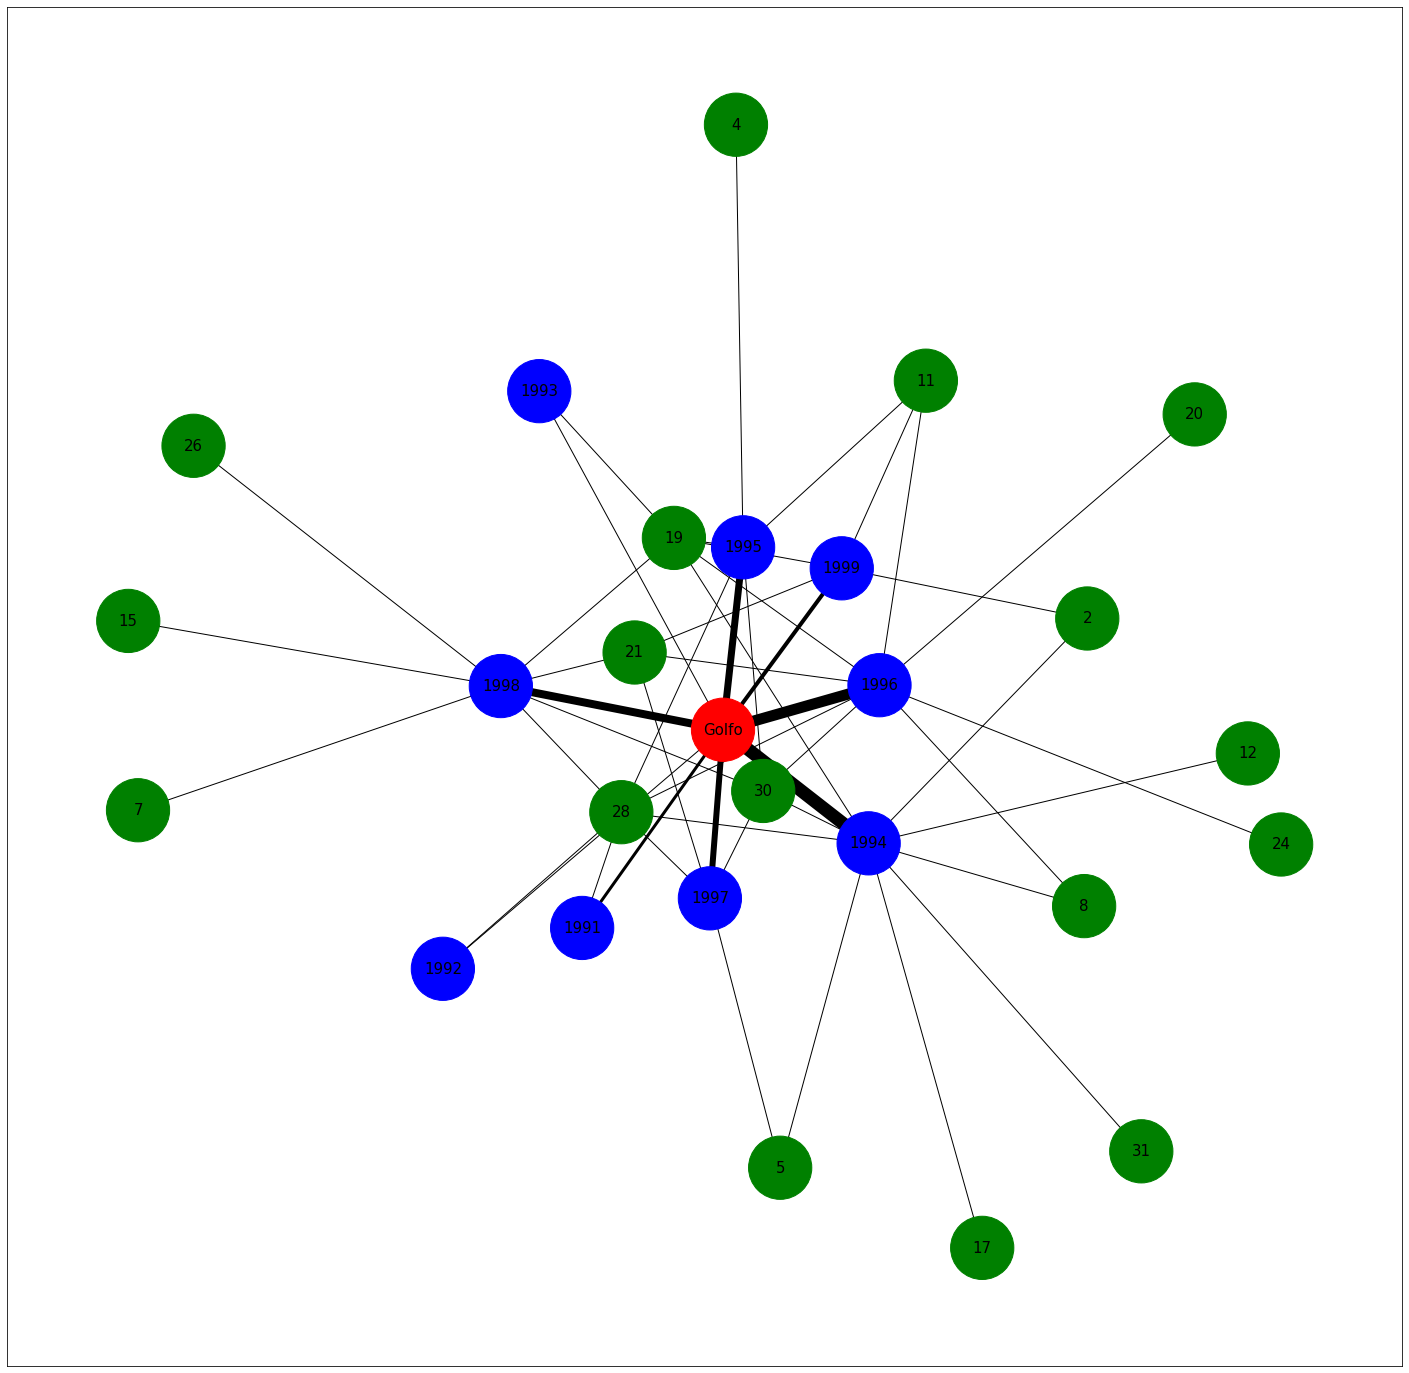

In [65]:
all_weights=[] #creo una lista con tutti i pesi degli edges
for (node1,node2,data) in net_golfo_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[] #creo una lista con tutti i colori dei nodi
for (node1,data) in net_golfo_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_golfo_9000,seed=1234) #imposto il layout della rete 

for weight in unique_weights: #creiamo i collegamenti nel nostro grafico tramite la lista dei pesi creata in precedenza
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_golfo_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_golfo_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_golfo_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_golfo_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

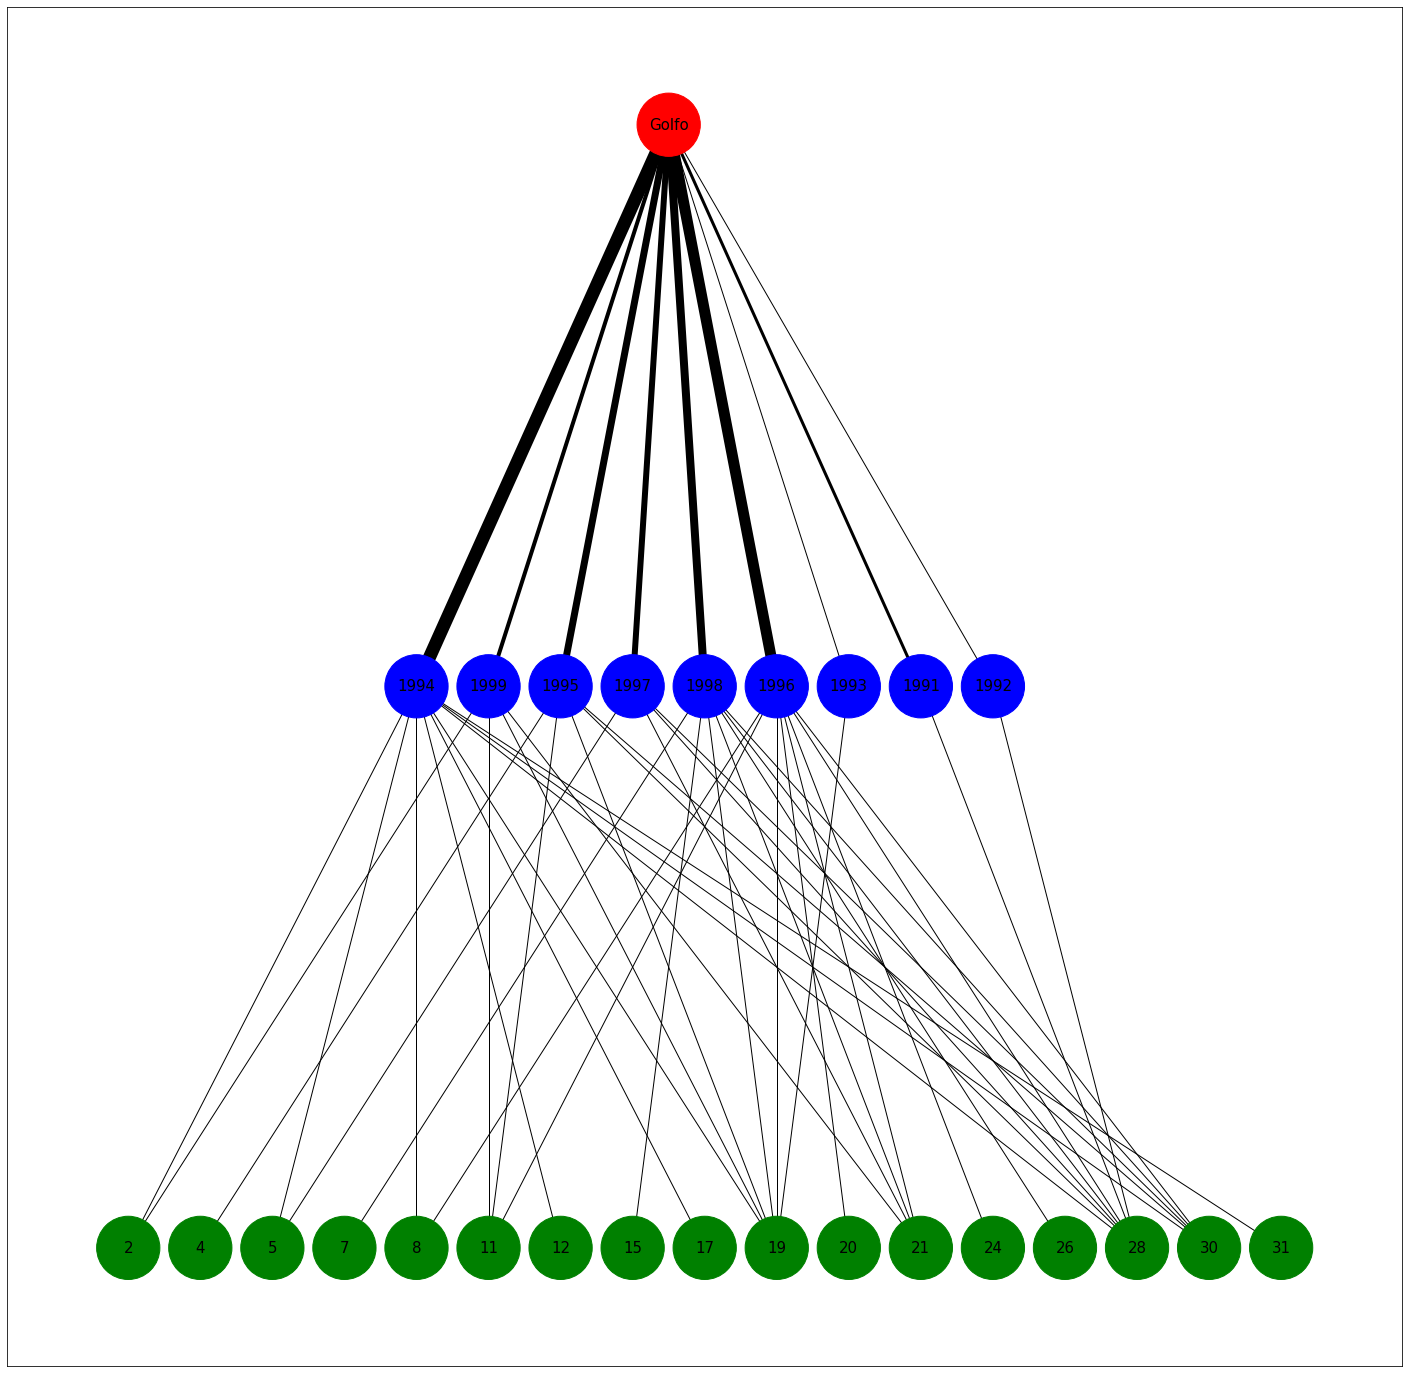

In [66]:
all_weights=[] #creo una lista con tutti i pesi degli edges
for (node1,node2,data) in net_golfo_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[] #creo una lista con tutti i colori dei nodi
for (node1,data) in net_golfo_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_golfo_9000,seed=1234) #imposto il layout della rete 

#modifichiamo la posizione dei nostri nodi
dto = ['Golfo']
years = ['1994', '1999', '1995', '1997', '1998', '1996', '1993', '1991', '1992']
states = ['2', '4', '5', '7', '8', '11', '12', '15', '17', '19', '20', '21', '24', '26', '28', '30', '31']

pos = {n: (8, 2) for i, n in enumerate(dto)}
pos.update({n: ( (4+i) + 0.5, 1) for i, n in enumerate(years)})
pos.update({n: ( i + 0.5, 0) for i, n in enumerate(states)})

for weight in unique_weights: #creiamo i collegamenti nel nostro grafico tramite la lista dei pesi creata in precedenza
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_golfo_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_golfo_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_golfo_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_golfo_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

In [67]:
#calcolo le metriche per la rete degli anni 1990-1999
metrics(net_golfo_9000,link_select=True, nodi_select=True,
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 49
# ------------------------------------------------------------ #
I nodi della rete sono: 27
# ------------------------------------------------------------ #
La somma dei node degree è: 98

L'average degree di questa network è: 3.6296296296296298

I valori degree maggiori sono: 
      Node  Degree
17   1994      10
22   1996       9
26  Golfo       9
21   1998       8
14     28       7

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.1396011396011396
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


creiamo la rete del cartello negli anni 2000-2010

In [68]:
net_golfo_0010 = nx.Graph()
sXy_golfo_0010 = pd.read_csv(percorso_cartella+'/state_year_Golfo_G0010.txt')
Network_Generator_For_Cartels(net_golfo_0010,sXy_golfo_0010,df_G0010,'Golfo')

In [69]:
nt = Network('1000px','1000px') 
nt.from_nx(net_golfo_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('golfo_0010.html')

In [70]:
#calcolo le metriche per la rete degli anni 2000-2010
metrics(net_golfo_0010,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 224
# ------------------------------------------------------------ #
I nodi della rete sono: 42
# ------------------------------------------------------------ #
La somma dei node degree è: 448

L'average degree di questa network è: 10.666666666666666

I valori degree maggiori sono: 
     Node  Degree
32  2008      30
31  2007      29
33  2009      29
30  2006      27
39  2010      27

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.2601626016260163
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


### Beltran Leyva 

creiamo la rete del cartello negli anni 2000-2010

In [71]:
net_bl_0010 = nx.Graph()
sXy_bl_0010 = pd.read_csv(percorso_cartella+'/state_year_Beltran_Leyva_BL0010.txt')
Network_Generator_For_Cartels(net_bl_0010,sXy_bl_0010,df_BL0010,'Beltran_Leyva')

In [72]:
metrics(net_bl_0010,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 158
# ------------------------------------------------------------ #
I nodi della rete sono: 40
# ------------------------------------------------------------ #
La somma dei node degree è: 316

L'average degree di questa network è: 7.9

I valori degree maggiori sono: 
     Node  Degree
32  2010      28
31  2009      27
30  2008      25
35  2005      21
37  2007      20

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.20256410256410257
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


In [73]:
nt = Network('1000px','1000px')

nt.from_nx(net_bl_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('bl_0010.html')

### Beltran Leyva Family

creiamo la rete del cartello negli anni 2000-2010

In [74]:
net_blf_0010 = nx.Graph()
sXy_blf_0010 = pd.read_csv(percorso_cartella+'/state_year_Beltran_Leyva_Family_BLF0010.txt')
Network_Generator_For_Cartels(net_blf_0010,sXy_blf_0010,df_BLF0010,'Beltran_Leyva_Family')

In [75]:
nt = Network('1000px','1000px')

nt.from_nx(net_blf_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('blf_0010.html')

### Familia

creiamo la rete del cartello negli anni 2000-2010

In [76]:
net_familia_0010 = nx.Graph()
sXy_familia_0010 = pd.read_csv(percorso_cartella+'/state_year_Familia_F0010.txt')
Network_Generator_For_Cartels(net_familia_0010,sXy_familia_0010,df_F0010,'Familia')

In [77]:
metrics(net_familia_0010,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 110
# ------------------------------------------------------------ #
I nodi della rete sono: 38
# ------------------------------------------------------------ #
La somma dei node degree è: 220

L'average degree di questa network è: 5.7894736842105265

I valori degree maggiori sono: 
     Node  Degree
34  2010      27
33  2009      23
32  2008      18
30  2005      17
31  2007      12

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.15647226173541964
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


In [78]:
nt = Network('1000px','1000px')

nt.from_nx(net_familia_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('familia_0010.html')

### Juarez

creiamo la rete del cartello negli anni 1990-1999

In [79]:
net_juarez_9000 = nx.Graph()
sXy_juarez_9000 = pd.read_csv(percorso_cartella+'/state_year_Juarez_J9000.txt')
Network_Generator_For_Cartels(net_juarez_9000,sXy_juarez_9000,df_J9000,'Juarez')

In [80]:
nt = Network('1000px', '1000px')
nt.from_nx(net_juarez_9000,show_edge_weights=True)
nt.show('juarez_9000.html')

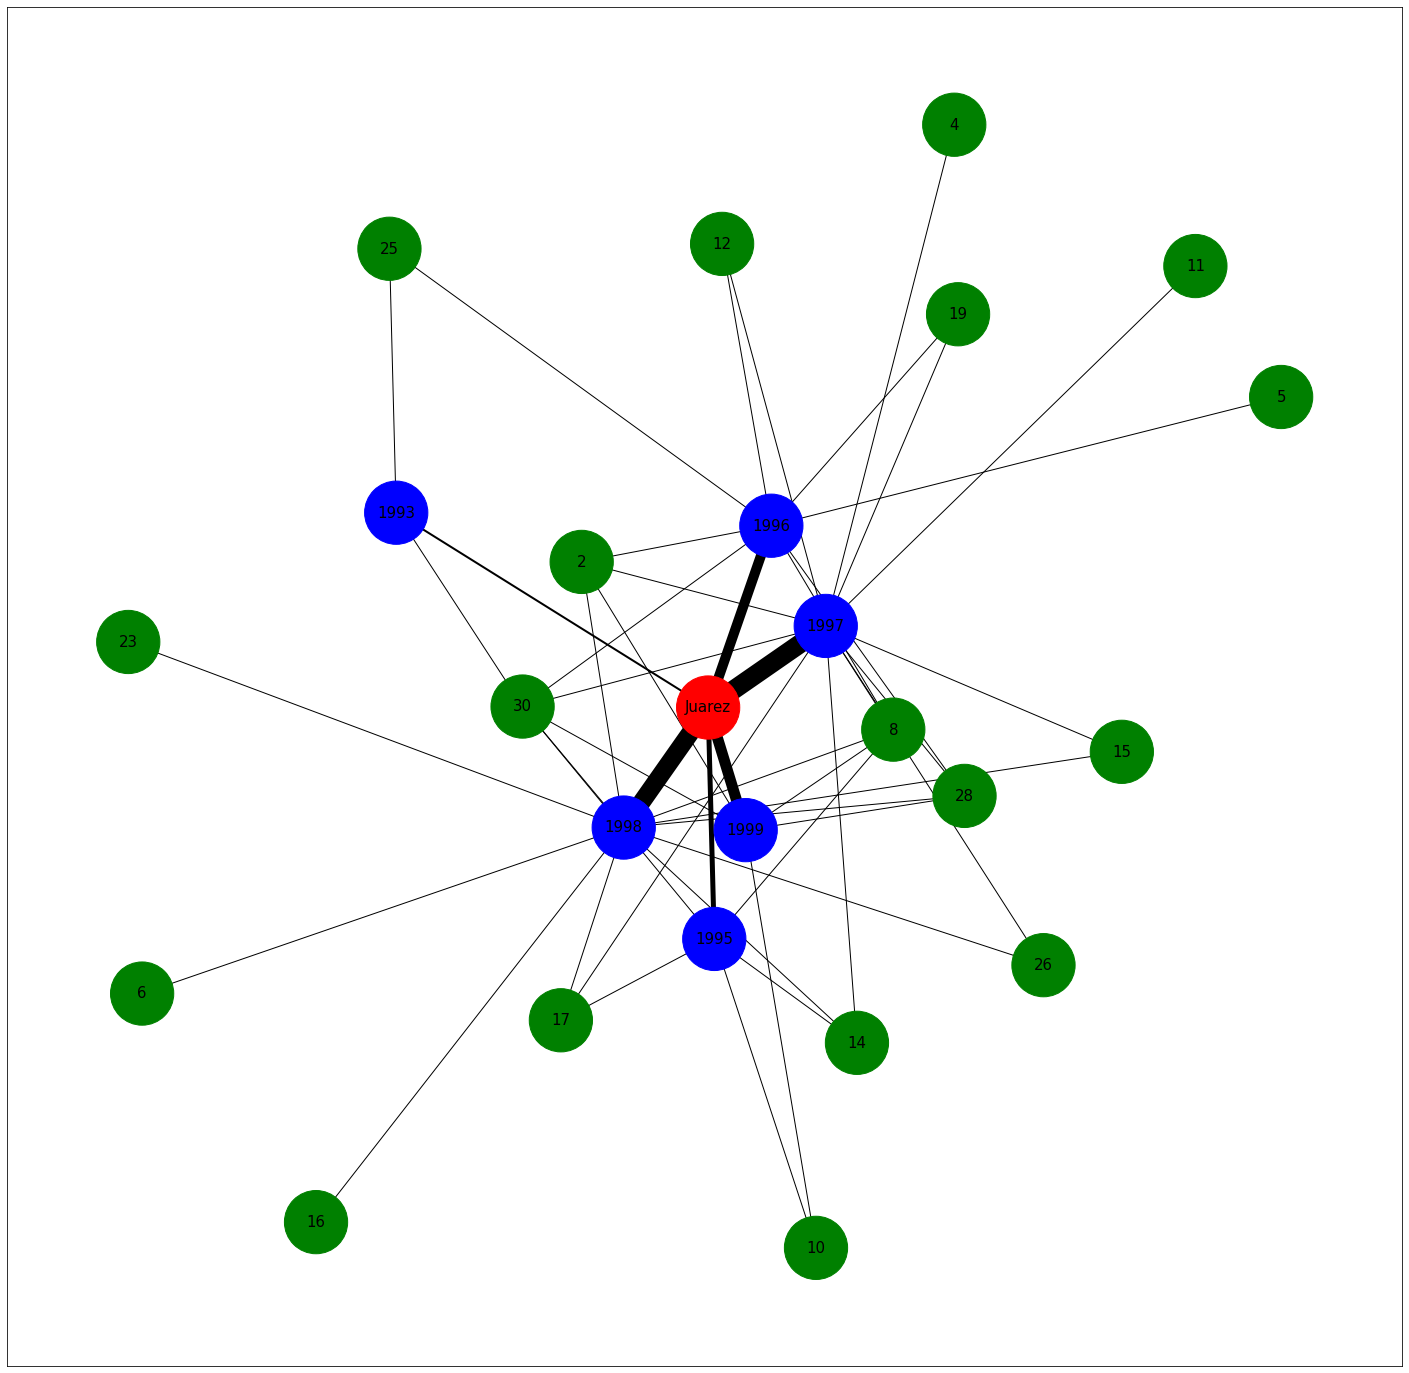

In [81]:
all_weights=[]
for (node1,node2,data) in net_juarez_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[]
for (node1,data) in net_juarez_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_juarez_9000,seed=1234)

for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_juarez_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_juarez_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_juarez_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_juarez_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

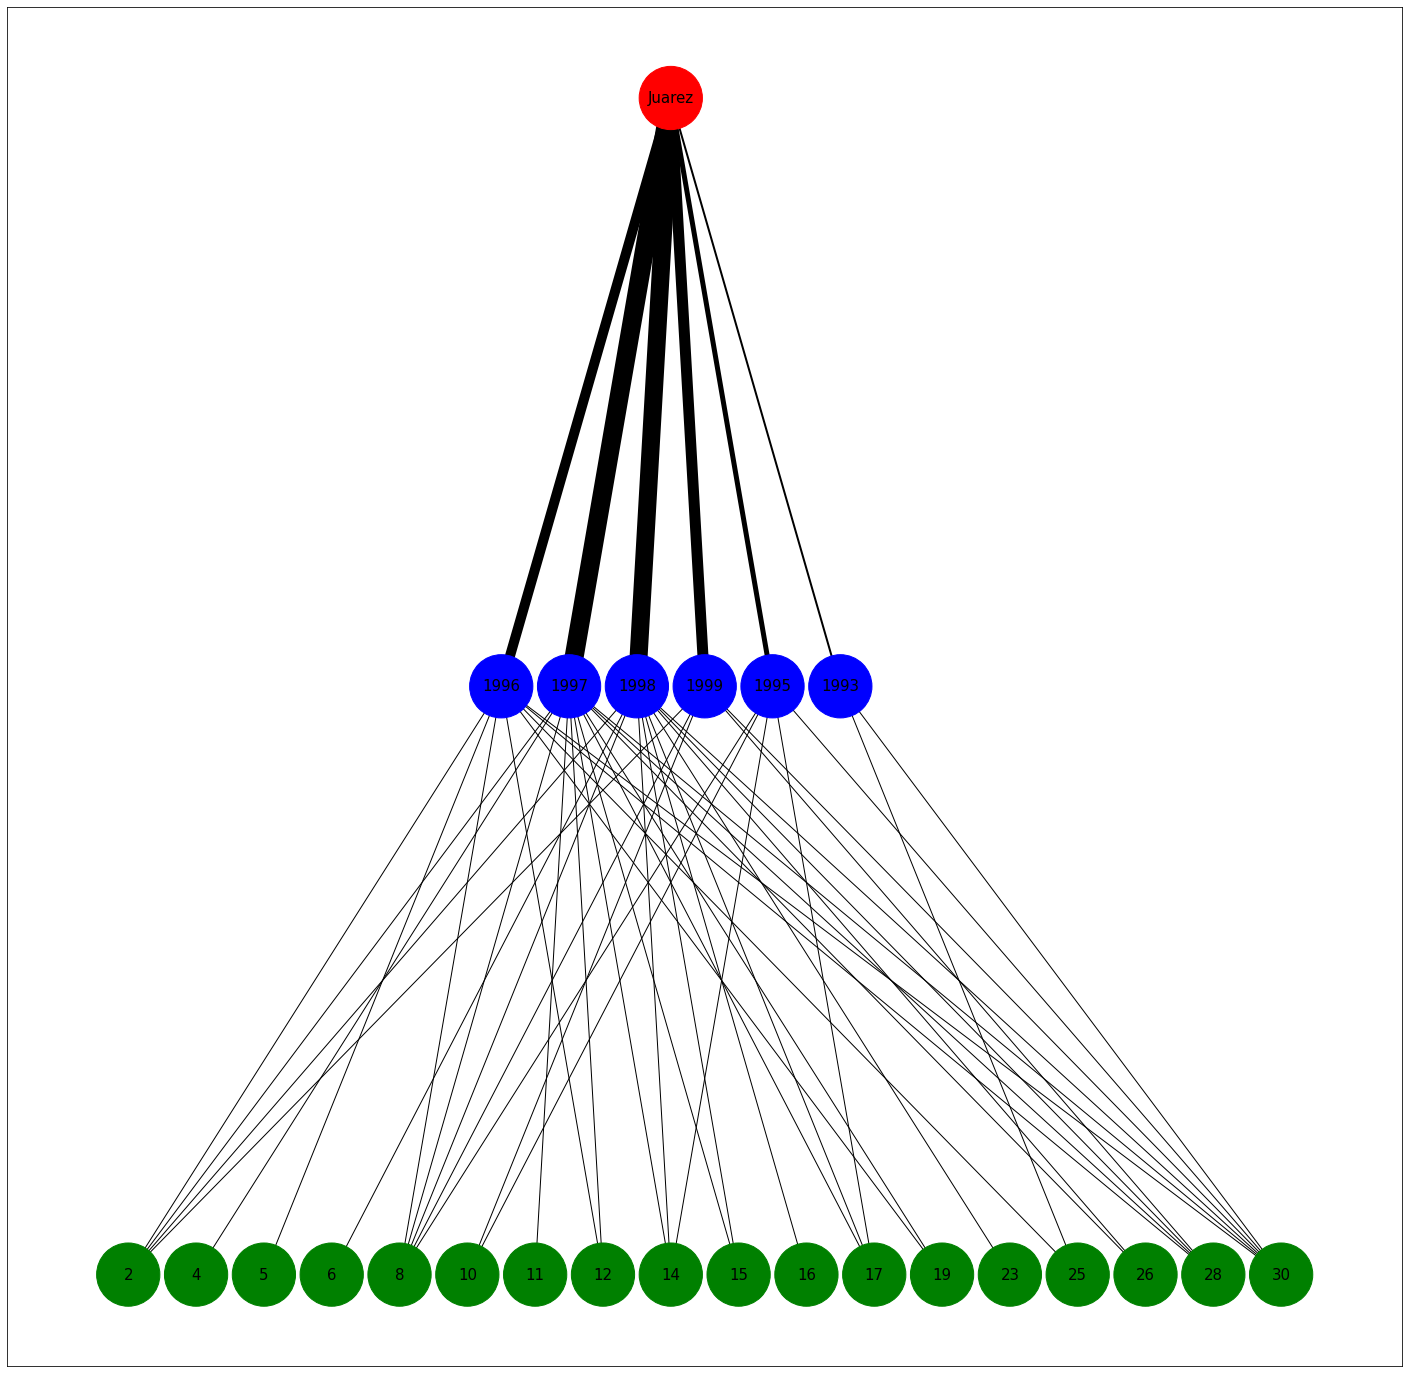

In [82]:
all_weights=[] #creo una lista con tutti i pesi degli edges
for (node1,node2,data) in net_juarez_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[] #creo una lista con tutti i colori dei nodi
for (node1,data) in net_juarez_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_juarez_9000,seed=1234) #imposto il layout della rete 

#modifichiamo la posizione dei nostri nodi
dto = ['Juarez']
years = ['1996', '1997', '1998', '1999', '1995', '1993']
states = ['2', '4', '5', '6', '8', '10', '11', '12', '14', '15', '16', '17', '19', '23', '25', '26', '28', '30']

pos = {n: (8.5, 2) for i, n in enumerate(dto)}
pos.update({n: ( (5.5+i) + 0.5, 1) for i, n in enumerate(years)})
pos.update({n: ( i + 0.5, 0) for i, n in enumerate(states)})

for weight in unique_weights: #creiamo i collegamenti nel nostro grafico tramite la lista dei pesi creata in precedenza
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_juarez_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_juarez_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_juarez_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_juarez_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

In [83]:
metrics(net_juarez_9000,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 49
# ------------------------------------------------------------ #
I nodi della rete sono: 25
# ------------------------------------------------------------ #
La somma dei node degree è: 98

L'average degree di questa network è: 3.92

I valori degree maggiori sono: 
     Node  Degree
19  1997      13
20  1998      12
18  1996       9
17    30       6
21  1999       6

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.16333333333333333
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


creiamo la rete del cartello negli anni 2000-2010

In [84]:
net_juarez_0010 = nx.Graph()
sXy_juarez_0010 = pd.read_csv(percorso_cartella+'/state_year_Juarez_J0010.txt')
Network_Generator_For_Cartels(net_juarez_0010,sXy_juarez_0010,df_J0010,'Juarez')

In [85]:
metrics(net_juarez_0010,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 156
# ------------------------------------------------------------ #
I nodi della rete sono: 40
# ------------------------------------------------------------ #
La somma dei node degree è: 312

L'average degree di questa network è: 7.8

I valori degree maggiori sono: 
     Node  Degree
33  2010      21
30  2005      19
35  2007      19
37  2009      18
31  2006      16

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.2
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


In [86]:
nt = Network('1000px','1000px')

nt.from_nx(net_juarez_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('juarez_0010.html')

### Sinaloa

creiamo la rete del cartello negli anni 1990-1999

In [87]:
net_sinaloa_9000 = nx.Graph()
sXy_sinaloa_9000 = pd.read_csv(percorso_cartella+'/state_year_Sinaloa_S9000.txt')
Network_Generator_For_Cartels(net_sinaloa_9000,sXy_sinaloa_9000,df_S9000,'Sinaloa')

In [88]:
nt = Network('1000px', '1000px')
nt.from_nx(net_sinaloa_9000,show_edge_weights=True)
nt.show('sinaloa_9000.html')

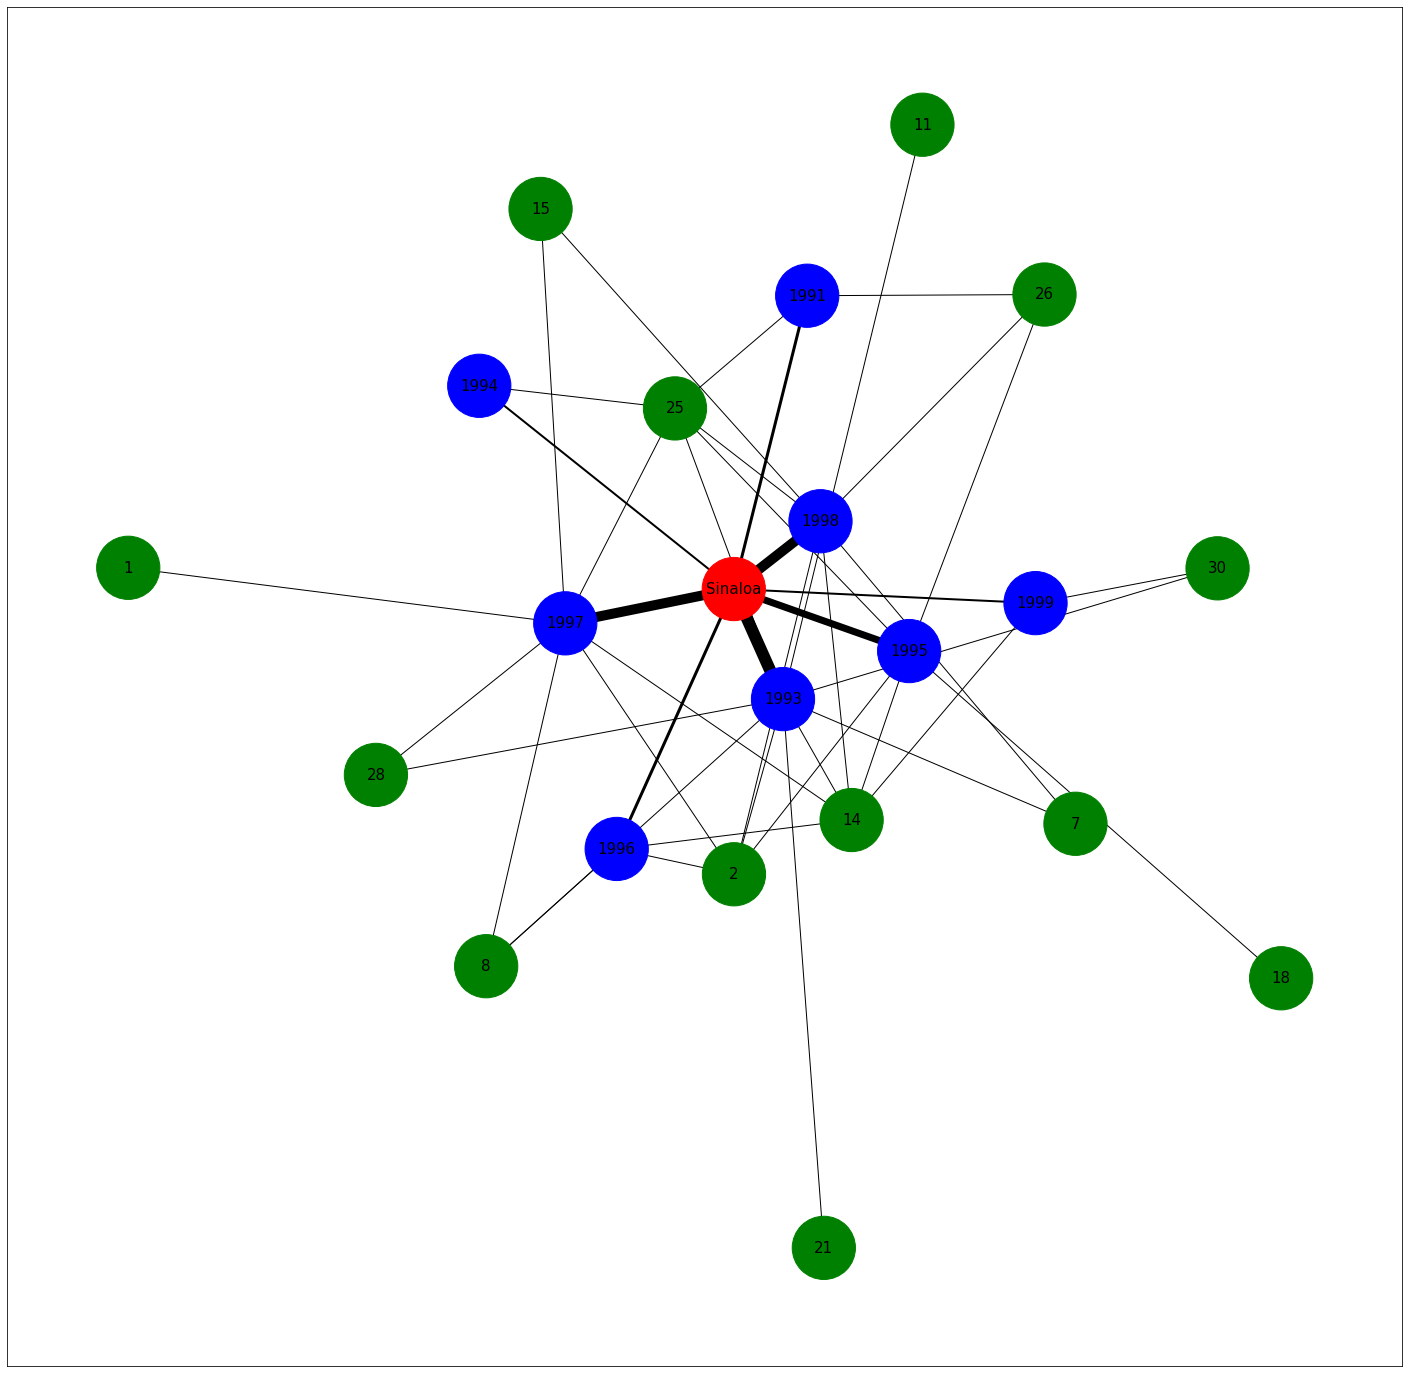

In [89]:
all_weights=[]
for (node1,node2,data) in net_sinaloa_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[]
for (node1,data) in net_sinaloa_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_sinaloa_9000,seed=1234)

for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_sinaloa_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_sinaloa_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_sinaloa_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_sinaloa_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

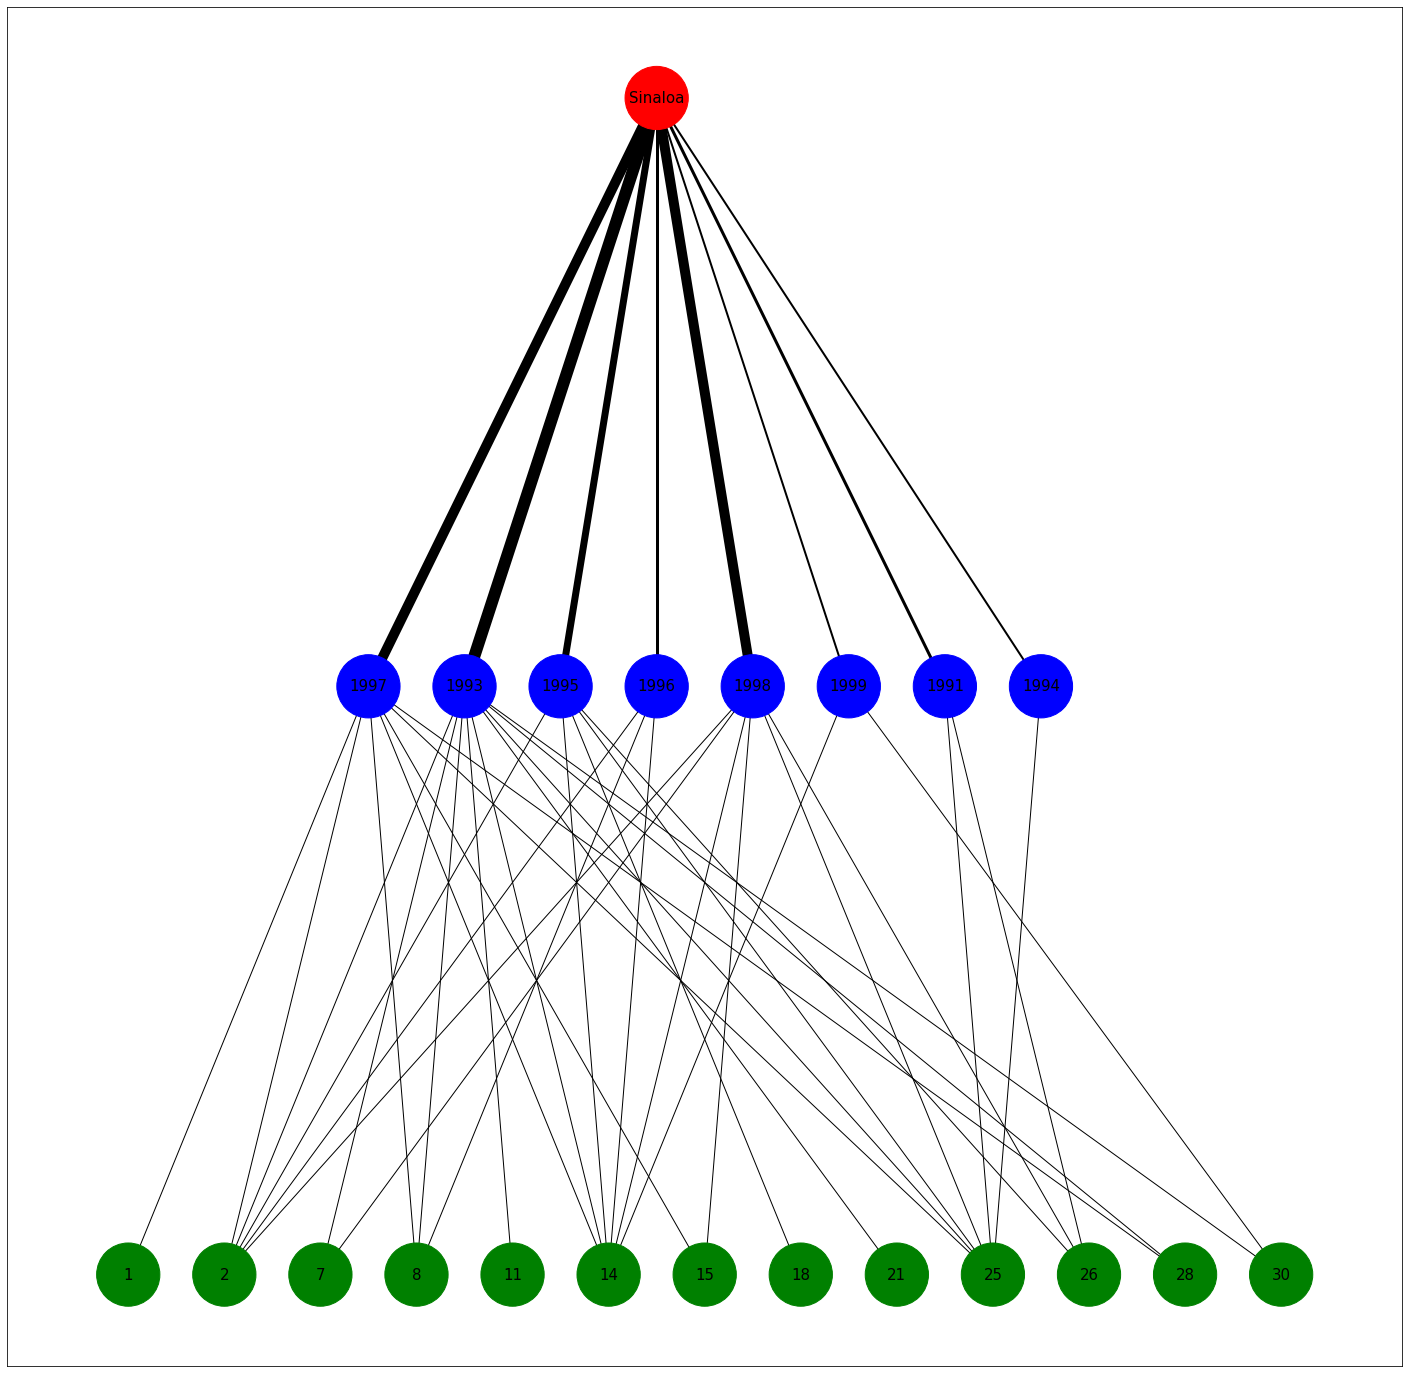

In [90]:
all_weights=[] #creo una lista con tutti i pesi degli edges
for (node1,node2,data) in net_sinaloa_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[] #creo una lista con tutti i colori dei nodi
for (node1,data) in net_sinaloa_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_sinaloa_9000,seed=1234) #imposto il layout della rete 

#modifichiamo la posizione dei nostri nodi
dto = ['Sinaloa']
years = ['1997', '1993', '1995', '1996', '1998', '1999', '1991', '1994']
states = ['1', '2', '7', '8', '11', '14', '15', '18', '21', '25', '26', '28', '30']

pos = {n: (6, 2) for i, n in enumerate(dto)}
pos.update({n: ( (2.5+i) + 0.5, 1) for i, n in enumerate(years)})
pos.update({n: ( i + 0.5, 0) for i, n in enumerate(states)})

for weight in unique_weights: #creiamo i collegamenti nel nostro grafico tramite la lista dei pesi creata in precedenza
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_sinaloa_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_sinaloa_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_sinaloa_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_sinaloa_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

In [91]:
metrics(net_sinaloa_9000,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 43
# ------------------------------------------------------------ #
I nodi della rete sono: 22
# ------------------------------------------------------------ #
La somma dei node degree è: 86

L'average degree di questa network è: 3.909090909090909

I valori degree maggiori sono: 
        Node  Degree
14     1993      10
13     1997       8
21  Sinaloa       8
17     1998       7
5        14       6

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.18614718614718614
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


creiamo la rete del cartello negli anni 2000-2010

In [92]:
net_sinaloa_0010 = nx.Graph()
sXy_sinaloa_0010 = pd.read_csv(percorso_cartella+'/state_year_Sinaloa_S0010.txt')
Network_Generator_For_Cartels(net_sinaloa_0010,sXy_sinaloa_0010,df_S0010,'Sinaloa')

In [93]:
nt = Network('1000px','1000px')

nt.from_nx(net_sinaloa_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('sinaloa_0010.html')

In [94]:
metrics(net_sinaloa_0010,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 223
# ------------------------------------------------------------ #
I nodi della rete sono: 43
# ------------------------------------------------------------ #
La somma dei node degree è: 446

L'average degree di questa network è: 10.372093023255815

I valori degree maggiori sono: 
     Node  Degree
36  2010      30
35  2009      28
34  2008      26
39  2006      26
32  2005      25

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.2469545957918051
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


### Sinaloa Family

creiamo la rete del cartello negli anni 2000-2010

In [95]:
net_sf_0010 = nx.Graph()
sXy_sf_0010 = pd.read_csv(percorso_cartella+'/state_year_Sinaloa_Family_SF0010.txt')
Network_Generator_For_Cartels(net_sf_0010,sXy_sf_0010,df_SF0010,'Sinaloa_Family')

In [96]:
nt = Network('1000px','1000px')

nt.from_nx(net_sf_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('sf_0010.html')

### Tijuana

creiamo la rete del cartello negli anni 1990-1999

In [97]:
net_tijuana_9000 = nx.Graph()
sXy_tijuana_9000 = pd.read_csv(percorso_cartella+'/state_year_Tijuana_T9000.txt')
Network_Generator_For_Cartels(net_tijuana_9000,sXy_tijuana_9000,df_T9000,'Tijuana')

In [98]:
nt = Network('1000px', '1000px')
nt.from_nx(net_tijuana_9000,show_edge_weights=True)
nt.show('tijuana_9000.html')

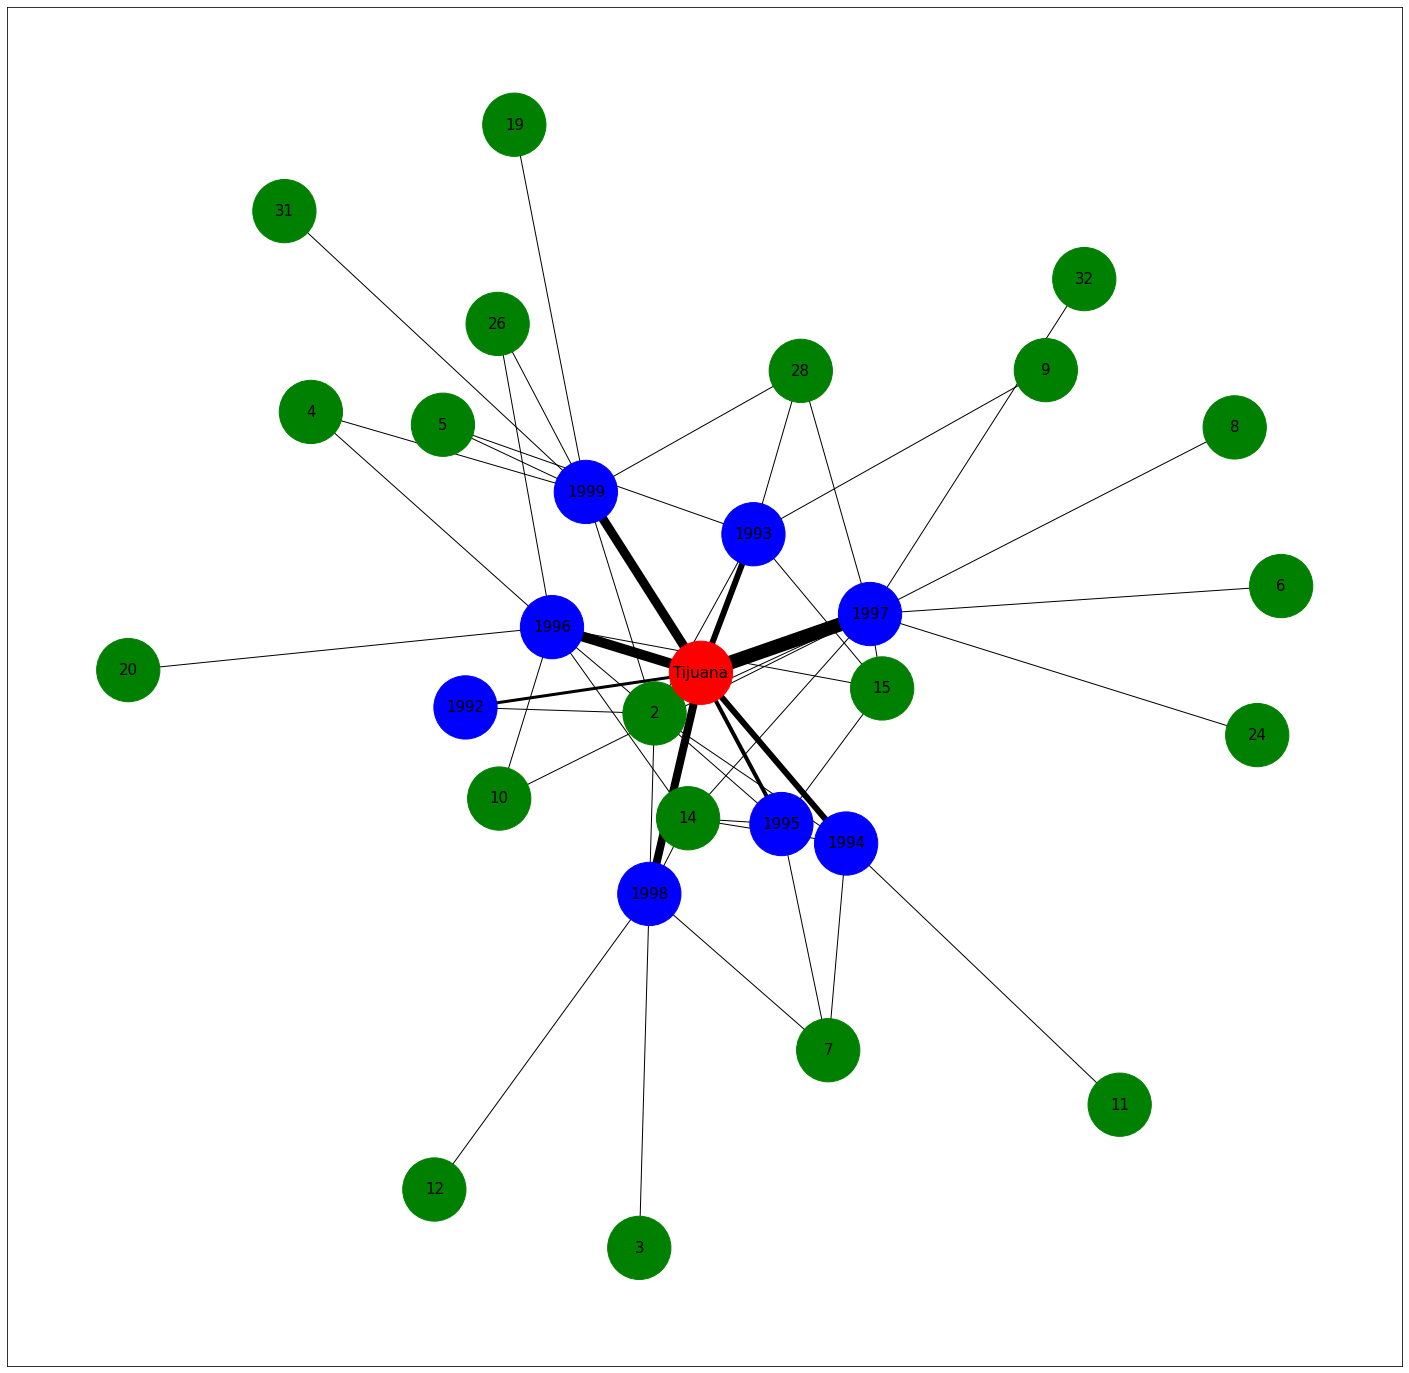

In [99]:
all_weights=[]
for (node1,node2,data) in net_tijuana_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[]
for (node1,data) in net_tijuana_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_tijuana_9000,seed=1234)

for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_tijuana_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_tijuana_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_tijuana_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_tijuana_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

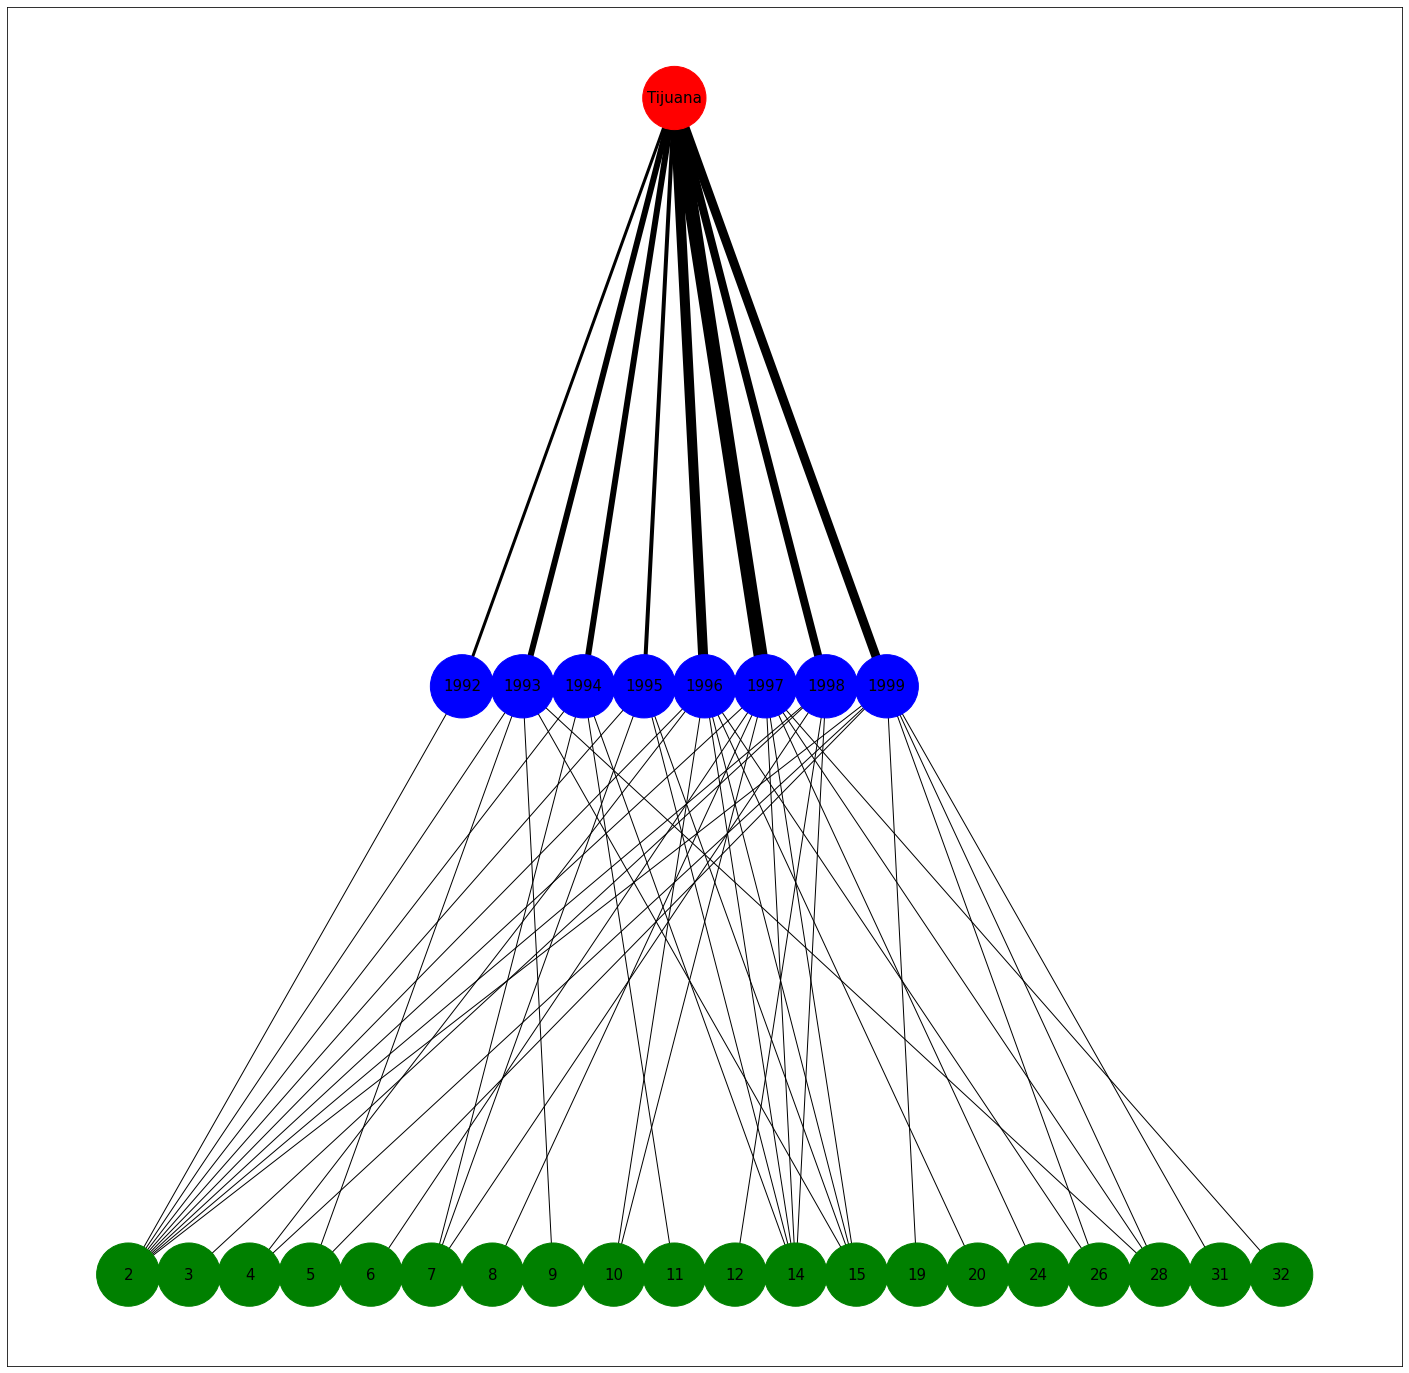

In [100]:
all_weights=[] #creo una lista con tutti i pesi degli edges
for (node1,node2,data) in net_tijuana_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[] #creo una lista con tutti i colori dei nodi
for (node1,data) in net_tijuana_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_tijuana_9000,seed=1234) #imposto il layout della rete 

#modifichiamo la posizione dei nostri nodi
dto = ['Tijuana']
years = ['1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999']
states = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '14', '15', '19', '20', '24', '26', '28', '31', '32']

pos = {n: (9.5, 2) for i, n in enumerate(dto)}
pos.update({n: ( (5.5+i) + 0.5, 1) for i, n in enumerate(years)})
pos.update({n: ( i + 0.5, 0) for i, n in enumerate(states)})

for weight in unique_weights: #creiamo i collegamenti nel nostro grafico tramite la lista dei pesi creata in precedenza
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_tijuana_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_tijuana_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_tijuana_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_tijuana_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

In [101]:
metrics(net_tijuana_9000,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 50
# ------------------------------------------------------------ #
I nodi della rete sono: 29
# ------------------------------------------------------------ #
La somma dei node degree è: 100

L'average degree di questa network è: 3.4482758620689653

I valori degree maggiori sono: 
        Node  Degree
25     1997      10
0         2       8
24     1996       8
27     1999       8
28  Tijuana       8

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.12315270935960591
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


creiamo la rete del cartello negli anni 2000-2010

In [102]:
net_tijuana_0010 = nx.Graph()
sXy_tijuana_0010 = pd.read_csv(percorso_cartella+'/state_year_Tijuana_T0010.txt')
Network_Generator_For_Cartels(net_tijuana_0010,sXy_tijuana_0010,df_T0010,'Tijuana')

In [103]:
nt = Network('1000px','1000px')

nt.from_nx(net_tijuana_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show('tijuana_0010.html')

In [104]:
metrics(net_tijuana_0010,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 139
# ------------------------------------------------------------ #
I nodi della rete sono: 36
# ------------------------------------------------------------ #
La somma dei node degree è: 278

L'average degree di questa network è: 7.722222222222222

I valori degree maggiori sono: 
     Node  Degree
34  2010      17
25  2006      15
31  2007      15
33  2009      15
24  2003      14

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.22063492063492063
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


### Zetas

creiamo la rete del cartello negli anni 1990-1999

In [105]:
net_zetas_9000 = nx.Graph()
sXy_zetas_9000 = pd.read_csv(percorso_cartella+'/state_year_Zetas_Z9000.txt')
Network_Generator_For_Cartels(net_zetas_9000,sXy_zetas_9000,df_Z9000,'Zetas')

In [106]:
nt = Network('1000px', '1000px')
nt.from_nx(net_zetas_9000,show_edge_weights=True)
nt.show('zetas_9000.html')

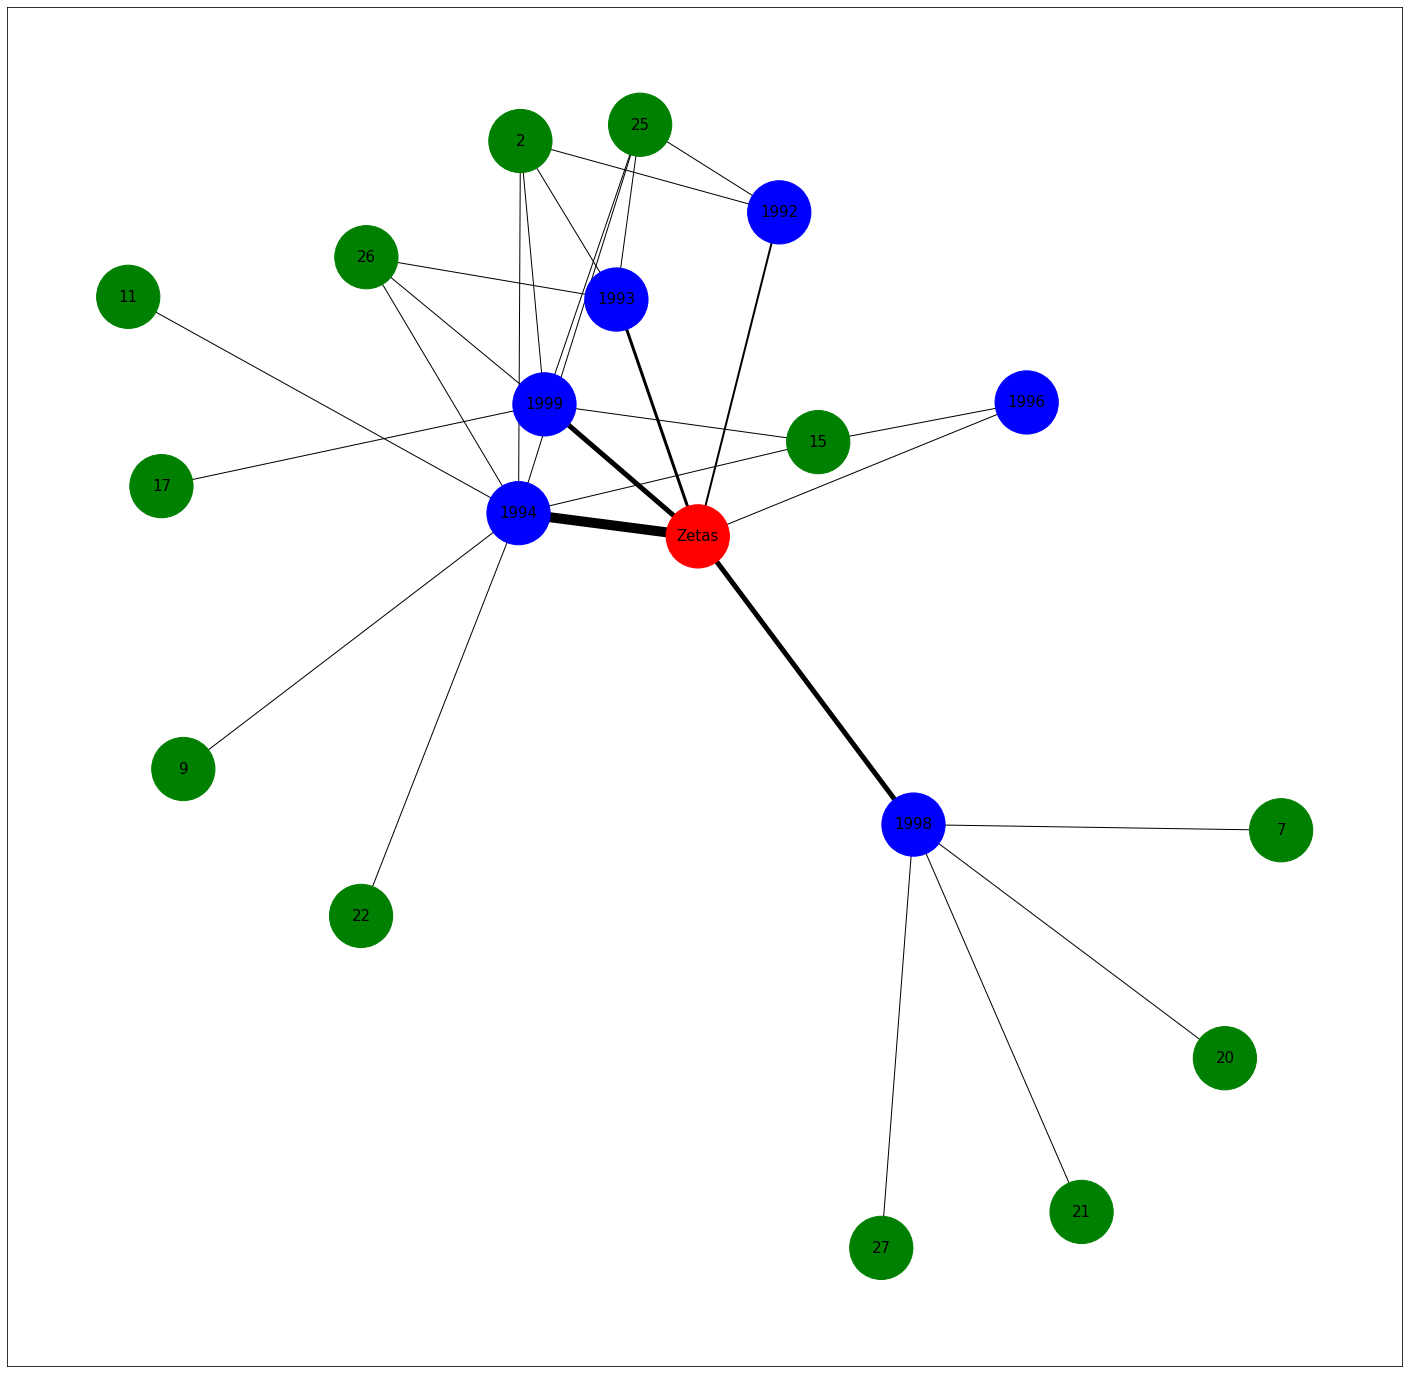

In [107]:
all_weights=[]
for (node1,node2,data) in net_zetas_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[]
for (node1,data) in net_zetas_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_zetas_9000,seed=1234)

for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_zetas_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_zetas_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_zetas_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_zetas_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

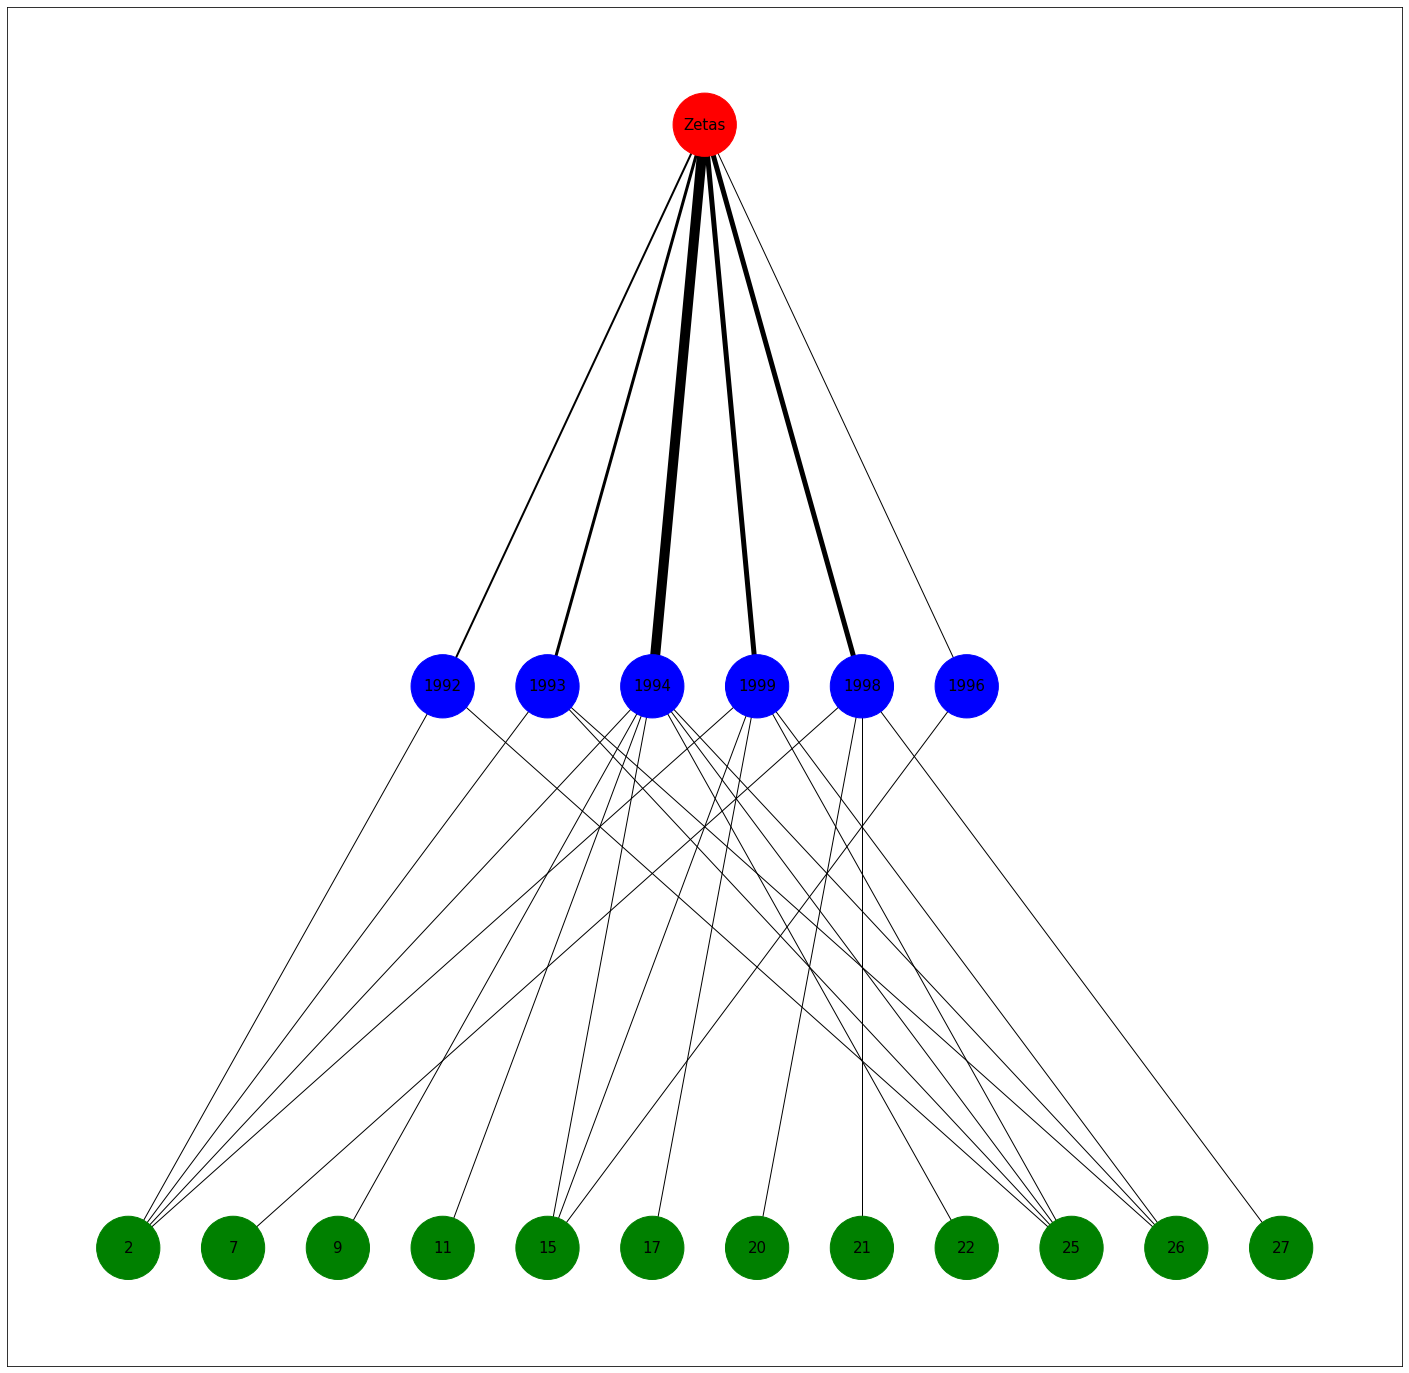

In [108]:
all_weights=[] #creo una lista con tutti i pesi degli edges
for (node1,node2,data) in net_zetas_9000.edges(data=True):
        all_weights.append(data['weight']) 

nodes_color=[] #creo una lista con tutti i colori dei nodi
for (node1,data) in net_zetas_9000.nodes(data=True):
        nodes_color.append(data['color']) 

unique_weights = list(set(all_weights))

pos = nx.spring_layout(net_zetas_9000,seed=1234) #imposto il layout della rete 

#modifichiamo la posizione dei nostri nodi
dto = ['Zetas']
years = ['1992', '1993', '1994', '1999', '1998', '1996']
states = ['2', '7', '9', '11', '15', '17', '20', '21', '22', '25', '26', '27']

pos = {n: (6, 2) for i, n in enumerate(dto)}
pos.update({n: ( (3+i) + 0.5, 1) for i, n in enumerate(years)})
pos.update({n: ( i + 0.5, 0) for i, n in enumerate(states)})

for weight in unique_weights: #creiamo i collegamenti nel nostro grafico tramite la lista dei pesi creata in precedenza
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_zetas_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_zetas_9000,pos,edgelist=weighted_edges,width=width)

nx.draw_networkx_nodes(net_zetas_9000,pos,node_color=nodes_color, node_size=4000)
nx.draw_networkx_labels(net_zetas_9000,pos,font_size=15, font_family="sans-serif")
plt.rcParams["figure.figsize"] = (25,25)

pass

In [109]:
metrics(net_zetas_9000,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 28
# ------------------------------------------------------------ #
I nodi della rete sono: 19
# ------------------------------------------------------------ #
La somma dei node degree è: 56

L'average degree di questa network è: 2.9473684210526314

I valori degree maggiori sono: 
      Node  Degree
14   1994       8
15   1999       6
18  Zetas       6
16   1998       5
0       2       4

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.16374269005847952
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


creiamo la rete del cartello negli anni 2000-2010

In [110]:
net_zetas_0010 = nx.Graph()
sXy_zetas_0010 = pd.read_csv(percorso_cartella+'/state_year_Zetas_Z0010.txt')
Network_Generator_For_Cartels(net_zetas_0010,sXy_zetas_0010,df_Z0010,'Zetas')

In [111]:
nt = Network('1000px','1000px')

nt.from_nx(net_zetas_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])

nt.show_buttons(filter_=True)
nt.show('zetas_0010.html')

In [112]:
metrics(net_zetas_0010,link_select=True, nodi_select=True, 
        degree_select=True, density_select=True, matrix_select=True)

Gli edge della rete sono: 204
# ------------------------------------------------------------ #
I nodi della rete sono: 42
# ------------------------------------------------------------ #
La somma dei node degree è: 408

L'average degree di questa network è: 9.714285714285714

I valori degree maggiori sono: 
     Node  Degree
34  2008      32
36  2010      32
35  2009      31
33  2007      30
32  2006      27

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.23693379790940766
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.


### Otros

creiamo la rete del cartello negli anni 2000-2010

In [113]:
net_otros_0010 = nx.Graph()
sXy_otros_0010 = pd.read_csv(percorso_cartella+'/state_year_otros_O0010.txt')
Network_Generator_For_Cartels(net_otros_0010,sXy_otros_0010,df_O0010,'Otros')

In [114]:
nt = Network('1000px','1000px')

nt.from_nx(net_otros_0010)

neighbor_map = nt.get_adj_list()
nt.repulsion(node_distance=200, spring_length=80)

for node in nt.nodes:
    node['value'] = len(neighbor_map[node['id']])
    
nt.show('otros_0010.html')

## Analisi delle Interazioni tra DTOs

creaiamo le proeiezioni per i cartelli

In [115]:
#1990-1999
y_1992 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1992','network_cartels_1992',1992)
y_1993 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1993','network_cartels_1993',1993)
y_1994 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1994','network_cartels_1994',1994)
y_1995 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1995','network_cartels_1995',1995)
y_1996 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1996','network_cartels_1996',1996)
y_1997 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1997','network_cartels_1997',1997)
y_1998 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1998','network_cartels_1998',1998)
y_1999 = Edges_Only_Cartel_Network_Final(dta_9000,'network_cartels_1999','network_cartels_1999',1999)

#concateniamo ogni dataset creato 
y_9000 = pd.concat([y_1992,y_1993,y_1994,y_1995,y_1996,y_1997,y_1998,y_1999])

In [116]:
#2000-2010
y_2000 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2000','network_cartels_2000',2000)
y_2001 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2001','network_cartels_2001',2001)
y_2002 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2002','network_cartels_2002',2002)
y_2003 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2003','network_cartels_2003',2003)
y_2004 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2004','network_cartels_2004',2004)
y_2005 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2005','network_cartels_2005',2005)
y_2006 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2006','network_cartels_2006',2006)
y_2007 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2007','network_cartels_2007',2007)
y_2008 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2008','network_cartels_2008',2008)
y_2009 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2009','network_cartels_2009',2009)
y_2010 = Edges_Only_Cartel_Network_Final(dta_0010,'network_cartels_2010','network_cartels_2010',2010)

#concateniamo ogni dataset creato
y_0010 = pd.concat([y_2000,y_2001,y_2002,y_2003,y_2004,y_2005,y_2006,y_2007,y_2008,y_2009,y_2010])

In [117]:
bi_grams_9000 = BiGram_Generator_Counter(y_9000) 
bi_grams_0010 = BiGram_Generator_Counter(y_0010)

In [118]:
bi_grams_9000.sort_values(by='W',ascending=False)

,A,B,W
3,Juarez,Sinaloa,15
1,Sinaloa,Tijuana,14
8,Golfo,Juarez,12
7,Juarez,Tijuana,11
0,Tijuana,Zetas,8
5,Golfo,Tijuana,6
9,Golfo,Sinaloa,5
2,Sinaloa,Zetas,4
6,Golfo,Zetas,4
4,Juarez,Zetas,2


In [119]:
bi_grams_0010.sort_values(by='W',ascending=False)

,A,B,W
16,Golfo,Zetas,169
3,Golfo,Sinaloa,155
8,Sinaloa,Zetas,153
11,Beltran_Leyva,Sinaloa,133
15,Beltran_Leyva,Zetas,133
12,Beltran_Leyva,Golfo,130
1,Juarez,Sinaloa,117
4,Golfo,Juarez,112
18,Juarez,Zetas,105
0,Sinaloa,Tijuana,98


procediamo con la visualizazione delle reti degli incontri

In [120]:
#creiamo le network degli incontri per la prima decade
net_9000 = nx.Graph()
Network_Cartels_Meeting_Generator(bi_grams_9000,net_9000,'#0ee5ba')

#creiamo le network degli incontri per la seconda decade
net_0010 = nx.Graph()
Network_Cartels_Meeting_Generator(bi_grams_0010,net_0010,'#0ee5ba')

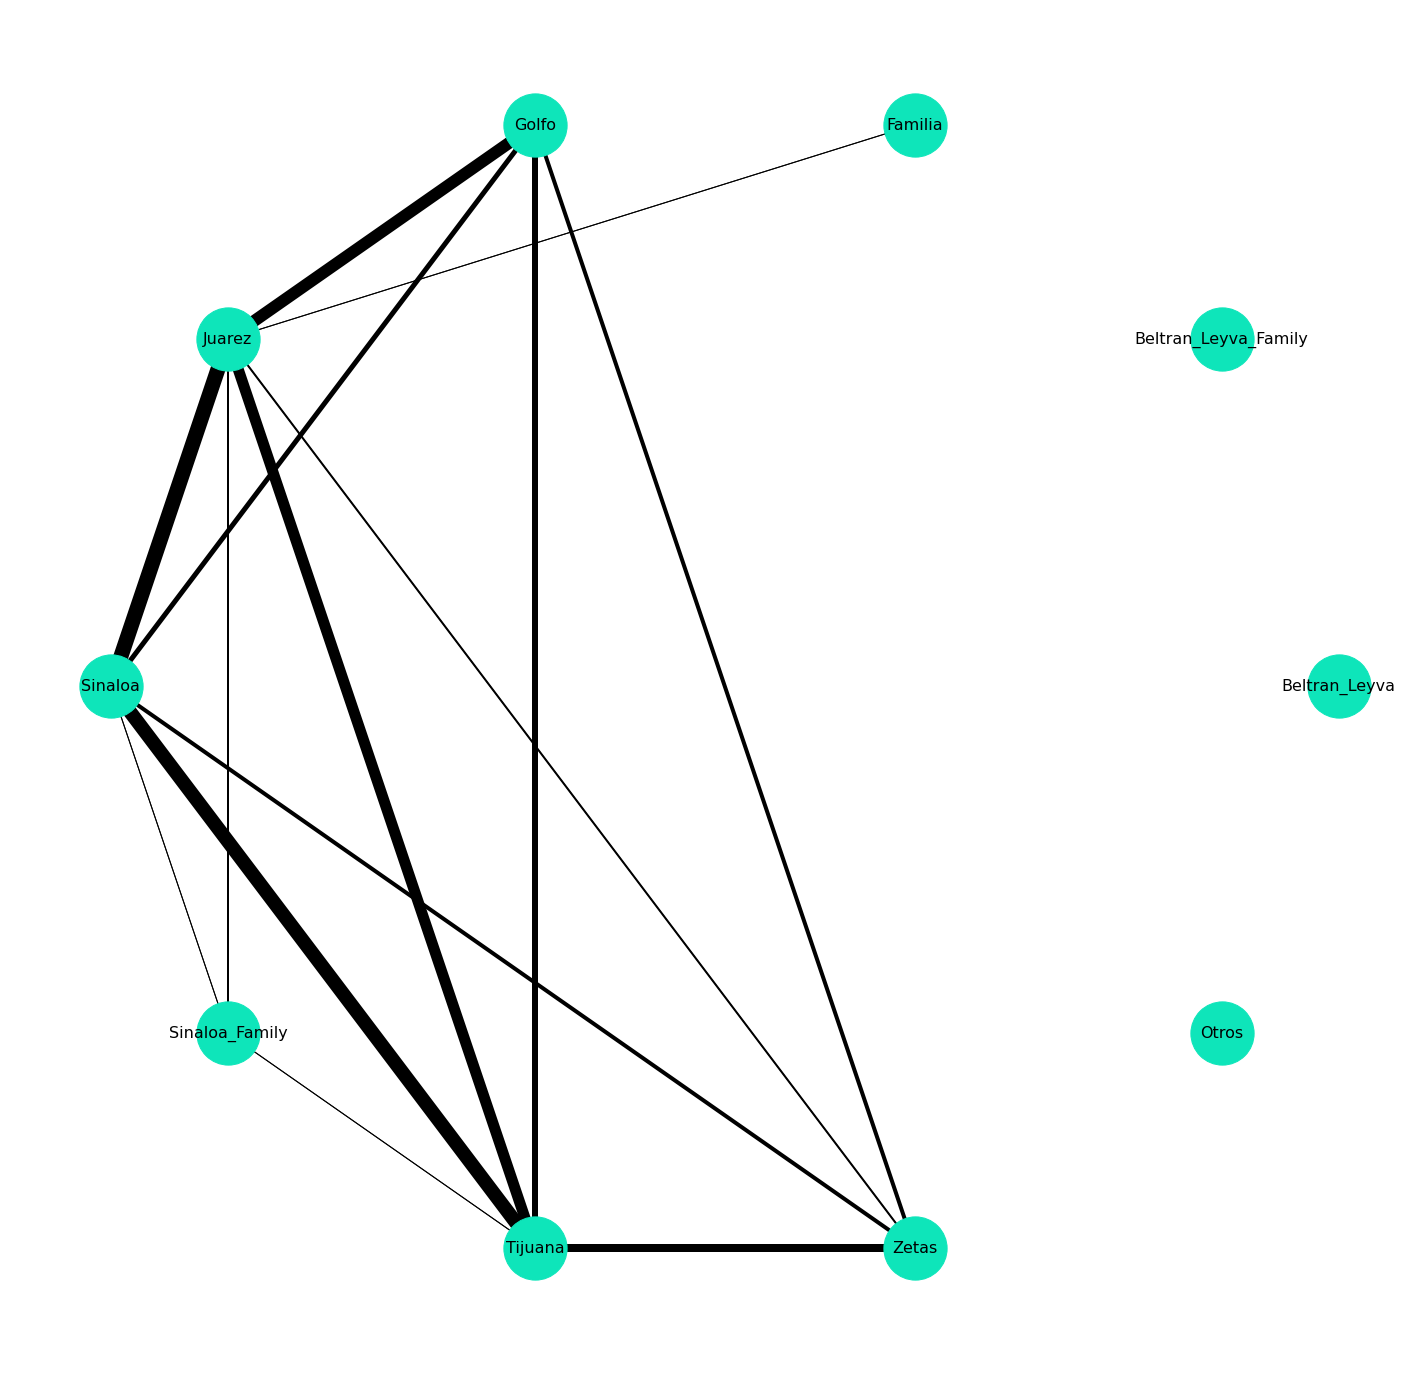

In [121]:
#grafico prima decade incontri cartelli
options = {
    "node_color" : '#0ee5ba', 
    "node_size" : 4000,
    "font_color" : 'black', 
    "font_size" : 16
}

pos=nx.circular_layout(net_9000)

all_weights=[]
for (node1,node2,data) in net_9000.edges(data=True):
        all_weights.append(data['weight']) 

unique_weights = list(set(all_weights))

for weight in unique_weights:
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in net_9000.edges(data=True) if edge_attr['weight']==weight]
        width = weight
        nx.draw_networkx_edges(net_9000,pos,edgelist=weighted_edges,width=width)

nx.draw(net_9000, pos, with_labels=True, **options)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [122]:
metrics(net_9000, all_metrics=True)

Gli edge della rete sono: 14
# ------------------------------------------------------------ #
I nodi della rete sono: 10
# ------------------------------------------------------------ #
La somma dei node degree è: 28

L'average degree di questa network è: 2.8

I valori degree maggiori sono: 
       Node  Degree
4   Juarez       6
5  Sinaloa       5
7  Tijuana       5
3    Golfo       4
8    Zetas       4

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 0.3111111111111111
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.
# ------------------------------------------------------------ #
I valori della Betweenness Centrality maggiori sono: 
                    Node    Values
4                Juarez  5.666667
5               Sinaloa  0.666667
7               Tijuana  0.666667
0         Beltran_Leyva  0.00

In [123]:
nx.betweenness_centrality(net_9000, weight='weight')

{'Beltran_Leyva': 0.0,
 'Beltran_Leyva_Family': 0.0,
 'Familia': 0.0,
 'Golfo': 0.0,
 'Juarez': 0.19444444444444442,
 'Sinaloa': 0.027777777777777776,
 'Sinaloa_Family': 0.16666666666666666,
 'Tijuana': 0.0,
 'Zetas': 0.05555555555555555,
 'Otros': 0.0}

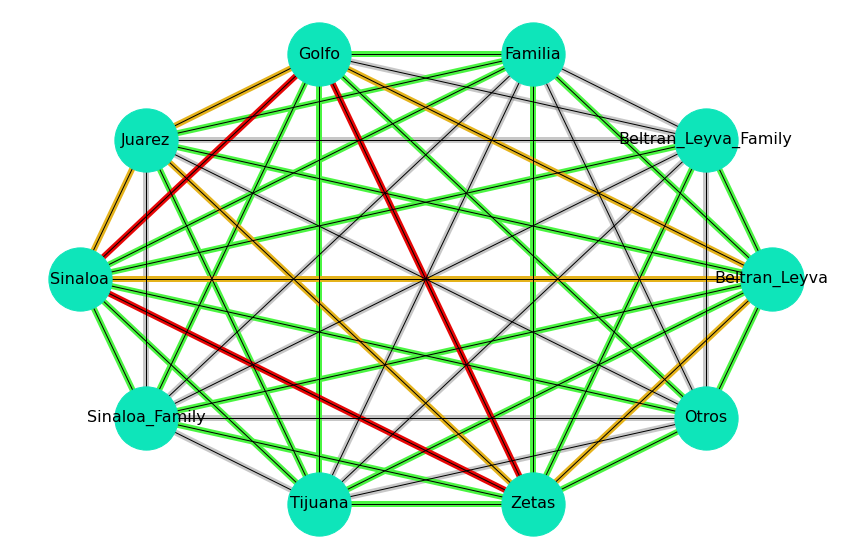

In [124]:
#dividiamo gli edges in base al loro peso
xs = [(u, v) for (u, v, d) in net_0010.edges(data=True) if d["weight"] <= 50]
s = [(u, v) for (u, v, d) in net_0010.edges(data=True) if d["weight"] > 50 and d["weight"] <= 100 ]
m = [(u, v) for (u, v, d) in net_0010.edges(data=True) if d["weight"] > 100 and d["weight"] < 150]
l = [(u, v) for (u, v, d) in net_0010.edges(data=True) if d["weight"] >= 150]

#assegniamo un colore agli edges in base alla loro taglia
nx.draw_networkx_edges(net_0010, pos, edgelist=xs, width=6,alpha=0.5, edge_color='#909090')
nx.draw_networkx_edges(net_0010, pos, edgelist=s, width=6 , edge_color="#4bf542")
nx.draw_networkx_edges(net_0010, pos, edgelist=m, width=6,edge_color="#e5b31c")
nx.draw_networkx_edges(net_0010, pos, edgelist=l, width=6, edge_color='#e70606' )

nx.draw(net_0010, pos, with_labels=True, **options)
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [125]:
metrics(net_0010, all_metrics=True)

Gli edge della rete sono: 45
# ------------------------------------------------------------ #
I nodi della rete sono: 10
# ------------------------------------------------------------ #
La somma dei node degree è: 90

L'average degree di questa network è: 9.0

I valori degree maggiori sono: 
                    Node  Degree
0         Beltran_Leyva       9
1  Beltran_Leyva_Family       9
2               Familia       9
3                 Golfo       9
4                Juarez       9

I restanti valori sono stati salvati nel file 'nodi_degree.csv'
# ------------------------------------------------------------ #
Densità della rete equivale a: 1.0
# ------------------------------------------------------------ #
La Matrice di adiacenza pesata è stata salvata correttamente.
# ------------------------------------------------------------ #
I valori della Betweenness Centrality maggiori sono: 
                    Node  Values
0         Beltran_Leyva     0.0
1  Beltran_Leyva_Family     0.0
2     

calcoliamo la strength dei cartelli per gli anni 2000-2010

In [126]:
a = bi_grams_0010[['A','W']].groupby(['A']).sum()
b = bi_grams_0010[['B','W']].groupby(['B']).sum()

a.to_csv('a.csv')
b.to_csv('b.csv')

a = pd.read_csv('a.csv')
b = pd.read_csv('b.csv')

a.rename(columns = {'A':'DTO'}, inplace = True)
b.rename(columns = {'B':'DTO'}, inplace = True)

col_str = [a,b]
str_0010 = pd.concat(col_str)
str_0010 = str_0010.groupby('DTO').sum().sort_values(by='W',ascending=False)
str_0010.to_csv('str_0010.csv')
df_str_0010 = pd.read_csv('str_0010.csv')

In [127]:
df_str_0010

,DTO,W
0,Sinaloa,932
1,Zetas,922
2,Golfo,916
3,Beltran_Leyva,806
4,Juarez,698
5,Familia,608
6,Tijuana,585
7,Otros,484
8,Sinaloa_Family,432
9,Beltran_Leyva_Family,395


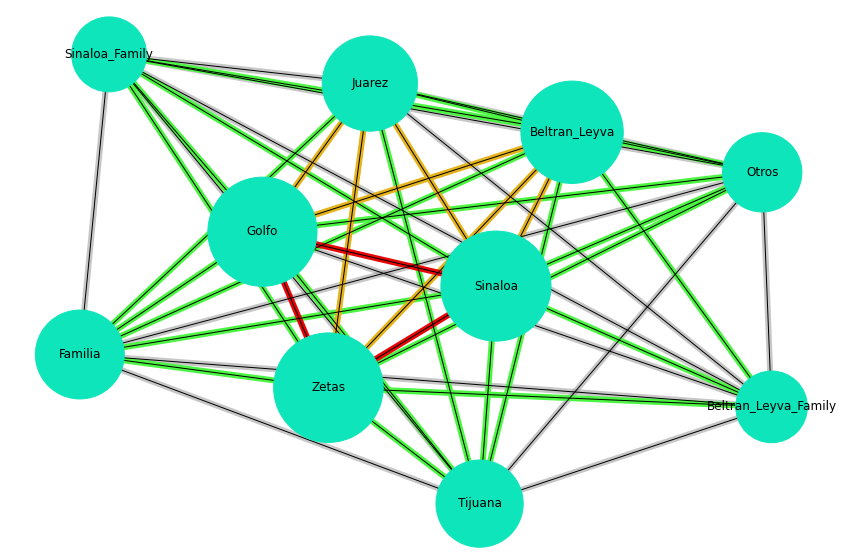

In [128]:
netX = nx.Graph()

ss=[]
for i in df_str_0010['DTO'].unique():
    s = df_str_0010.W.loc[(df_str_0010['DTO'] == i)].iloc[0]
    ss.append(s)
    netX.add_node(i, size = s)

edges_cartels = bi_grams_0010.values.tolist()
for i in range(len(edges_cartels)):
        edge = edges_cartels[i]
        add = -1

        for o in range(len(edge)):
            add = add + 1
            
            if add == 0:
                A = edge[add]
                
            elif add == 1:
                B = edge[add]
            elif add == 2:
                W = edge[add]

        netX.add_edge(str(A), str(B) ,weight=int(W))

pos=nx.spring_layout(netX,seed=2410)

#dividiamo gli edges in base al loro peso
xs = [(u, v) for (u, v, d) in netX.edges(data=True) if d["weight"] <= 50]
s = [(u, v) for (u, v, d) in netX.edges(data=True) if d["weight"] > 50 and d["weight"] <= 100 ]
m = [(u, v) for (u, v, d) in netX.edges(data=True) if d["weight"] > 100 and d["weight"] < 150]
l = [(u, v) for (u, v, d) in netX.edges(data=True) if d["weight"] >= 150]

#assegniamo un colore agli edges in base alla loro taglia
nx.draw_networkx_edges(netX, pos, edgelist=xs, width=6,alpha=0.5, edge_color='#909090')
nx.draw_networkx_edges(netX, pos, edgelist=s, width=6 , edge_color="#4bf542")
nx.draw_networkx_edges(netX, pos, edgelist=m, width=6,edge_color="#e5b31c")
nx.draw_networkx_edges(netX, pos, edgelist=l, width=6, edge_color='#e70606' )

nx.draw(netX,pos,with_labels=True,node_size=[v*13 for v in ss],node_color='#0ee5ba')
plt.show()